# Multiplane z-drift
- Z-drift vs water
    - Need to check their targeted depth distribution
- Z-drift vs depth difference
- Efficacy of online motion correction
    - For both "global" and "pairwise" protocols
- From the episodic mean FOV, rather than first last
    - Some weird error from first last
- Continued from 240222_... and 240325_... notebooks

In [1]:
import brain_observatory_qc.pipeline_dev.scripts.depth_estimation_module as dem
from pathlib import Path
import numpy as np
import pandas as pd
import h5py
from datetime import datetime
from matplotlib import pyplot as plt
from allensdk.brain_observatory.behavior.behavior_project_cache import VisualBehaviorOphysProjectCache as bpc
from brain_observatory_qc.data_access import from_lims
from pymongo import MongoClient
from visual_behavior import database as db
from datetime import datetime
import seaborn as sns
import matplotlib as mpl
from allensdk.brain_observatory.behavior.behavior_ophys_experiment import \
    BehaviorOphysExperiment
from scipy.interpolate import interp1d

mongo = MongoClient('flaskapp.corp.alleninstitute.org', 27017)

zdrift_dir = Path(r'\\allen\programs\mindscope\workgroups\learning\ophys\zdrift')
plane_interval = 0.75

def get_depth_region_from_db(oeid):
    query = '''
    SELECT oe.id, st.acronym, oe.calculated_depth, imd.depth
    FROM ophys_experiments oe
    JOIN structures st ON st.id = oe.targeted_structure_id
    JOIN imaging_depths imd ON imd.id = oe.imaging_depth_id
    WHERE oe.id = {}
    '''.format(oeid)
    lims_results = db.lims_query(query)
    return lims_results.depth.values[0], lims_results.acronym.values[0]


def get_zdrift_results(osid, load_dir):
    oeids = from_lims.get_ophys_experiment_ids_for_ophys_session_id(osid).ophys_experiment_id.values
    corrcoef = []
    matched_plane_indices = []
    for oeid in oeids:
        try:
            ocid = from_lims.get_ophys_container_id_for_ophys_experiment_id(oeid)
        except:
            ocid = 'none'
        zdrift_fn = load_dir / f'container_{ocid}' / f'experiment_{oeid}' / f'{oeid}_zdrift_ref_{oeid}.h5'
        
        with h5py.File(zdrift_fn) as h:
            corrcoef.append([np.max(cc) for cc in h['corrcoef'][:]])
            matched_plane_indices.append(h['matched_plane_indices'][:])
    return corrcoef, matched_plane_indices, oeids

def get_zdrift_results_first_last(osid, load_dir):
    oeids = from_lims.get_ophys_experiment_ids_for_ophys_session_id(osid).ophys_experiment_id.values
    corrcoef = []
    matched_plane_indices = []
    for oeid in oeids:
        try:
            ocid = from_lims.get_ophys_container_id_for_ophys_experiment_id(oeid)
        except:
            ocid = 'none'
        zdrift_fn = load_dir / f'container_{ocid}' / f'experiment_{oeid}' / f'{oeid}_zdrift_ref_{oeid}_first_last.h5'
        with h5py.File(zdrift_fn) as h:
            corrcoef.append([np.max(cc) for cc in h['corrcoef'][:]])
            matched_plane_indices.append(h['matched_plane_indices'][:])
    return corrcoef, matched_plane_indices, oeids


In [71]:
cache = bpc.from_lims()
table = cache.get_ophys_experiment_table(passed_only=False)

# GAD2 data
- From 240222_multiplane_zdrift_comparison.ipynb

In [95]:
lamf_table_fn = zdrift_dir / 'multiplane_zdrift_lamf.pkl'
lamf_table = pd.read_pickle(lamf_table_fn)

lamf_table.set_index('oeid',inplace=True,drop=True)
# add mouse_id to it
lamf_table['mouse_id'] = table.loc[lamf_table.index, 'mouse_id']
lamf_table.reset_index(drop=False,inplace=True)

lamf_table['min_cc_episodes'] = lamf_table.apply(lambda x: np.min([x['cc_episodes'][0], x['cc_episodes'][-1]]), axis=1)
lamf_table['min_cc_fl'] = lamf_table.apply(lambda x: np.min(x.cc_fl), axis=1)
lamf_table['zdrift_episodes'] = lamf_table.apply(lambda x: plane_interval * (x.mpi_episodes[-1] - x.mpi_episodes[0]), axis=1)
lamf_table['zdrift_fl'] = lamf_table.apply(lambda x: plane_interval * (x.mpi_fl[1] - x.mpi_fl[0]), axis=1)


C:\Users\jinho.kim\AppData\Roaming\Python\Python38\site-packages\pandas\core\indexes\base.py:6999: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)


Text(0.5, 1.0, 'GAD2 2x4')

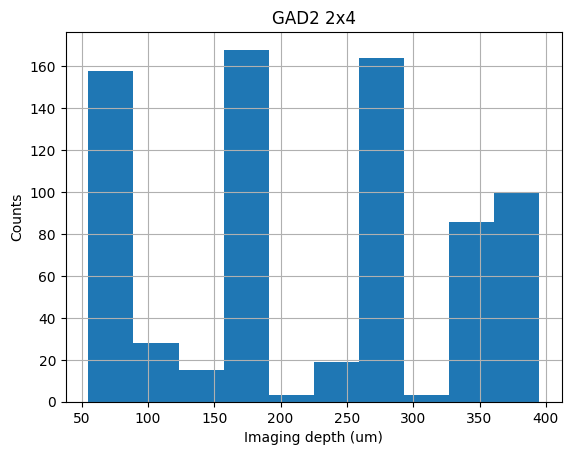

In [4]:
fig, ax = plt.subplots()
lamf_table.query('config=="2x4"').imaging_depth.hist(ax=ax)
ax.set_xlabel('Imaging depth (um)')
ax.set_ylabel('Counts')
ax.set_title('GAD2 2x4')

Text(0.5, 1.0, 'GAD2 1x8')

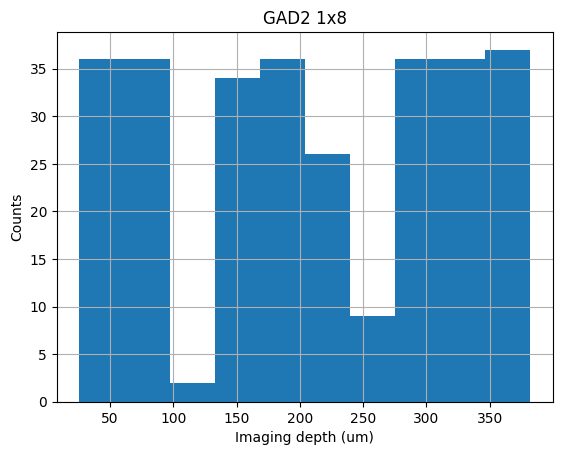

In [7]:
fig, ax = plt.subplots()
lamf_table.query('config=="1x8"').imaging_depth.hist(ax=ax)
ax.set_xlabel('Imaging depth (um)')
ax.set_ylabel('Counts')
ax.set_title('GAD2 1x8')

In [15]:
print('2x4')
osids = lamf_table.query('config=="2x4"').ophys_session_id.unique()
print(table.query('ophys_session_id in @osids').mouse_id.unique().size)
print(len(osids))
print('1x8')
osids = lamf_table.query('config=="1x8"').ophys_session_id.unique()
print(table.query('ophys_session_id in @osids').mouse_id.unique().size)
print(len(osids))


2x4
8
93
1x8
3
36


## 1x8 data

In [5]:
lamf_table.mouse_id.unique()

array(['671833', '710343', '690308', '681721', '662491', '704576',
       '703340', '681417', '677594', '711414', '662253'], dtype=object)

In [9]:
ex_mouse_id = '704576'
mouse_table = lamf_table.query('mouse_id== @ex_mouse_id')
mouse_table.ophys_session_id.unique()

array([1326437510, 1325702798, 1325496014, 1325954010, 1326197073,
       1327350251, 1326968345, 1328512625, 1327146245, 1327592860,
       1327858060, 1328804699, 1329555156], dtype=int64)

In [12]:
mouse_table.groupby('ophys_session_id').water.unique()

ophys_session_id
1325496014      [1.0350000000000001]
1325702798      [1.1900000000000002]
1325954010                    [0.88]
1326197073                    [0.91]
1326437510      [1.1300000000000001]
1326968345                   [0.935]
1327146245                   [0.795]
1327350251                   [0.921]
1327592860                    [0.97]
1327858060      [0.7460000000000001]
1328512625                   [0.781]
1328804699      [0.7460000000000001]
1329555156    [0.024999999999999967]
Name: water, dtype: object

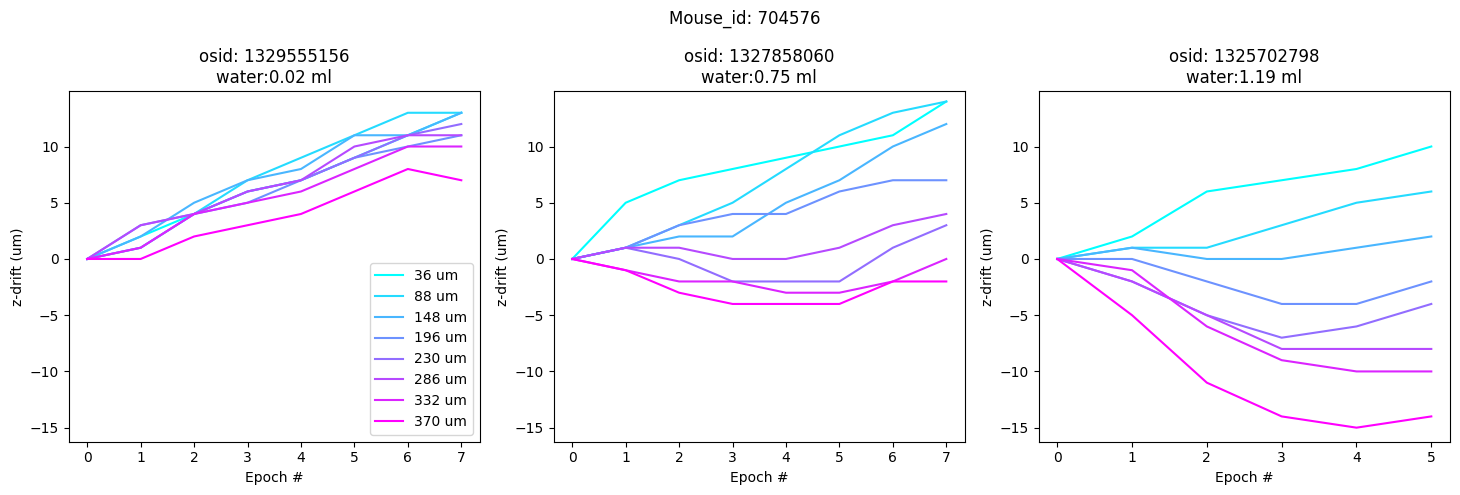

In [59]:
osids = [1329555156, 1327858060, 1325702798]
fig, ax = plt.subplots(1, len(osids), figsize=(5*len(osids), 5))
y_max = 0
y_min = 0
import matplotlib as mpl
colors = mpl.cm.get_cmap('cool')
for i, osid in enumerate(osids):
    session_table = lamf_table.query('ophys_session_id== @osid').sort_values(by='imaging_depth')
    water = session_table.water.unique()[0]
    num_planes = len(session_table)
    for ii, oeid in enumerate(session_table.index):
        zdrift = session_table.loc[oeid, 'mpi_episodes']
        zdrift = zdrift - zdrift[0]
        ax[i].plot(range(len(zdrift)), zdrift,
                   color=colors(ii/(num_planes-1)),
                   label=f'{int(session_table.loc[oeid, "imaging_depth"])} um')
    ax[i].set_title(f'osid: {osid}\nwater:{water:.2f} ml')
    ax[i].set_xlabel('Epoch #')
    ax[i].set_ylabel('z-drift (um)')
    y_max = max(y_max, ax[i].get_ylim()[1])
    y_min = min(y_min, ax[i].get_ylim()[0])
ax[0].legend(loc='lower right')
for i in range(len(osids)):
    ax[i].set_ylim(y_min, y_max)
    # ax[i].invert_yaxis()
fig.suptitle(f'Mouse_id: {ex_mouse_id}')
fig.tight_layout(rect=[0, 0, 0.98, 1])

No handles with labels found to put in legend.


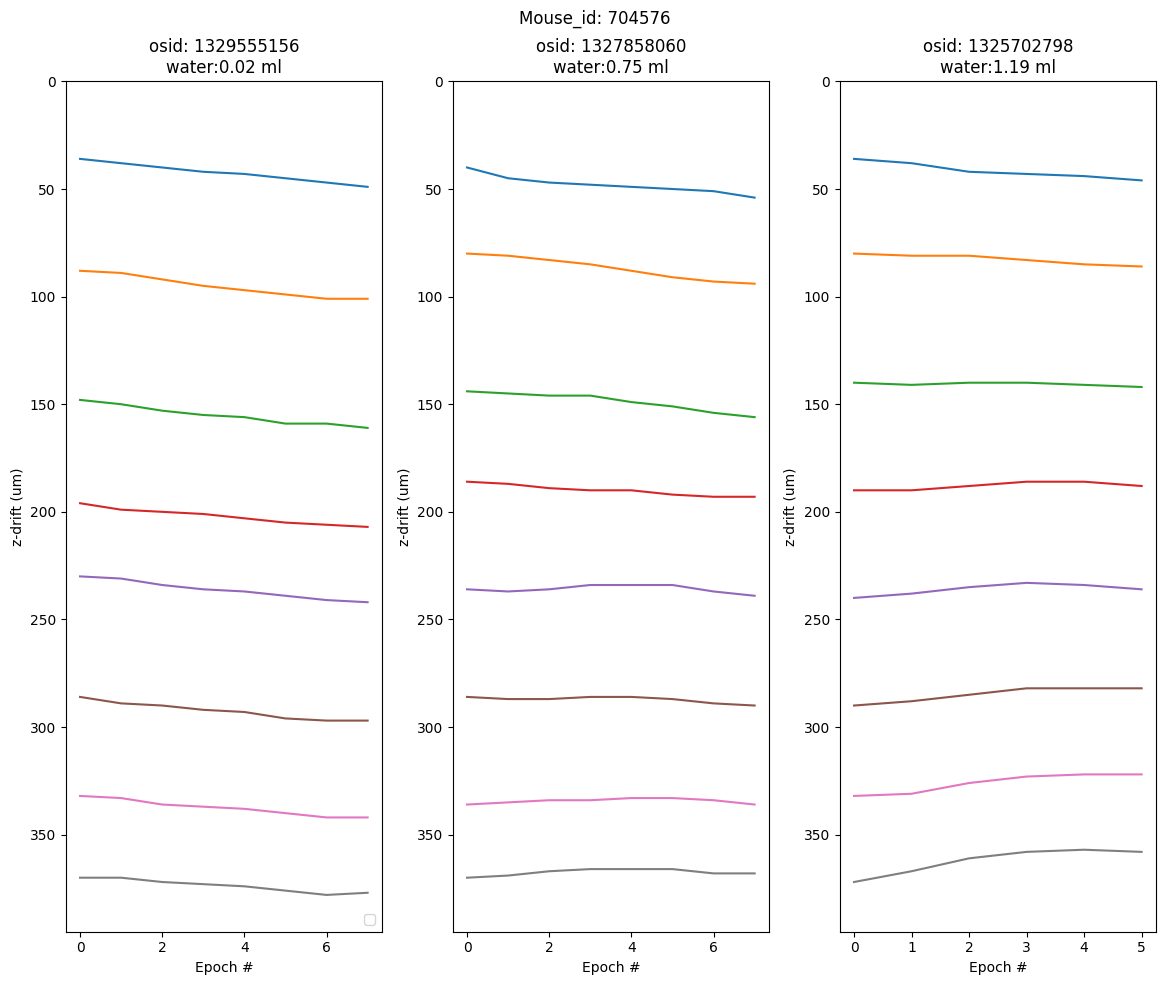

In [43]:
osids = [1329555156, 1327858060, 1325702798]
fig, ax = plt.subplots(1, len(osids), figsize=(4*len(osids), 10))
y_max = 0
y_min = 0
for i, osid in enumerate(osids):
    session_table = lamf_table.query('ophys_session_id== @osid').sort_values(by='imaging_depth')
    water = session_table.water.unique()[0]
    for oeid in session_table.index:
        zdrift = session_table.loc[oeid, 'mpi_episodes']
        zdrift = zdrift - zdrift[0]
        target_depth = int(session_table.loc[oeid, "imaging_depth"])
        ax[i].plot(range(len(zdrift)), zdrift + target_depth)
    ax[i].set_title(f'osid: {osid}\nwater:{water:.2f} ml')
    ax[i].set_xlabel('Epoch #')
    ax[i].set_ylabel('z-drift (um)')
    y_max = max(y_max, ax[i].get_ylim()[1])
    y_min = min(y_min, ax[i].get_ylim()[0])
ax[0].legend(loc='lower right')
for i in range(len(osids)):
    ax[i].set_ylim(y_min, y_max)
    # invert y axis
    ax[i].invert_yaxis()
fig.suptitle(f'Mouse_id: {ex_mouse_id}')
fig.tight_layout(rect=[0, 0, 0.98, 1])

### z-drift without water
- general direction

In [15]:
temp_table = lamf_table.query('config=="1x8" and water < 0.2')

In [17]:
temp_table.ophys_session_id.unique()

array([1331164473, 1331788264, 1330991697, 1329555156], dtype=int64)

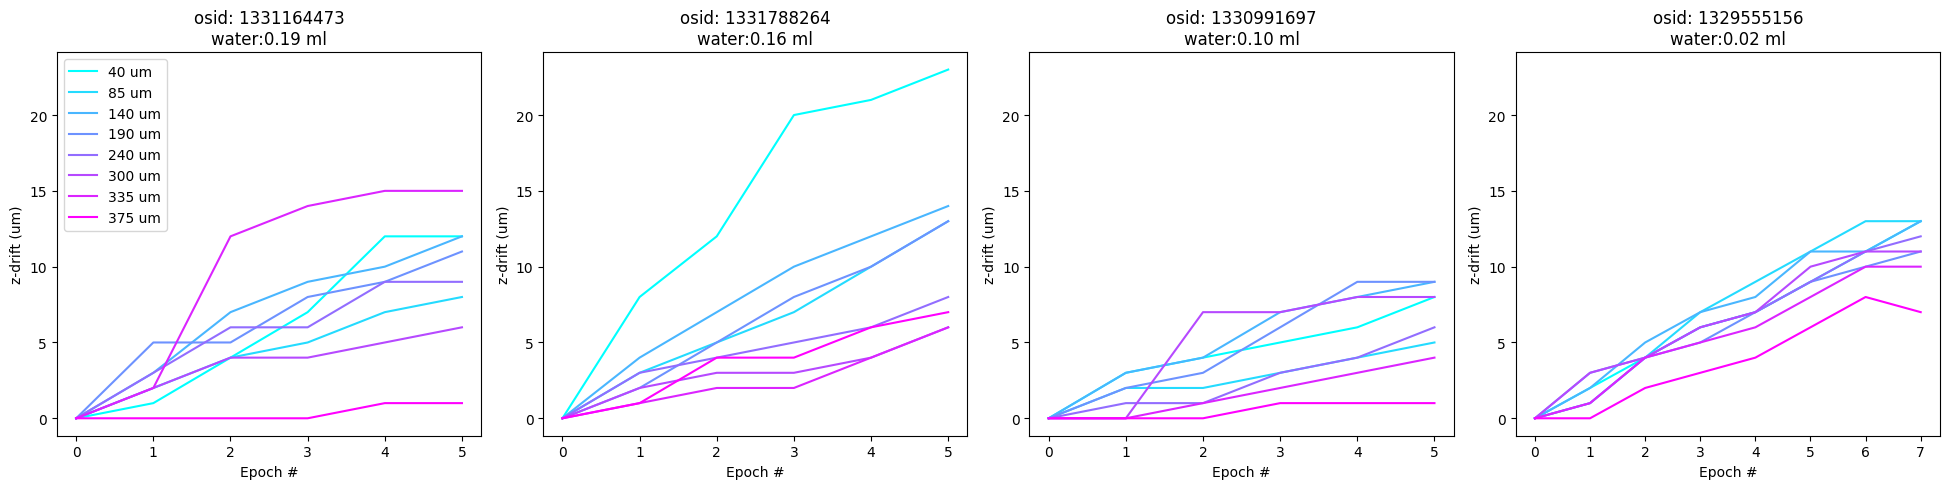

In [20]:
osids = temp_table.ophys_session_id.unique()
fig, ax = plt.subplots(1, len(osids), figsize=(5*len(osids), 5))
y_max = 0
y_min = 0
import matplotlib as mpl
colors = mpl.cm.get_cmap('cool')
for i, osid in enumerate(osids):
    session_table = lamf_table.query('ophys_session_id== @osid').sort_values(by='imaging_depth')
    water = session_table.water.unique()[0]
    num_planes = len(session_table)
    for ii, oeid in enumerate(session_table.index):
        zdrift = session_table.loc[oeid, 'mpi_episodes']
        zdrift = zdrift - zdrift[0]
        ax[i].plot(range(len(zdrift)), zdrift,
                   color=colors(ii/(num_planes-1)),
                   label=f'{int(session_table.loc[oeid, "imaging_depth"])} um')
    ax[i].set_title(f'osid: {osid}\nwater:{water:.2f} ml')
    ax[i].set_xlabel('Epoch #')
    ax[i].set_ylabel('z-drift (um)')
    y_max = max(y_max, ax[i].get_ylim()[1])
    y_min = min(y_min, ax[i].get_ylim()[0])
ax[0].legend(loc='upper left')
for i in range(len(osids)):
    ax[i].set_ylim(y_min, y_max)
    # ax[i].invert_yaxis()
# fig.suptitle(f'Mouse_id: {ex_mouse_id}')
fig.tight_layout(rect=[0, 0, 0.98, 1])

## Brain motion vs hydration
- compare between using first/last 500 frames and using episodic mean FOVs
- First check reliable calculation based on correlation coefficients

In [96]:
temp_table = lamf_table.query('config=="1x8"').copy()
temp_table.reset_index(drop=False, inplace=True)

temp_table = temp_table.merge(temp_table.groupby('ophys_session_id')['zdrift_episodes'].var(),
                          left_on='ophys_session_id',
                          right_on='ophys_session_id',
                          suffixes=('', '_var'))
temp_table = temp_table.merge(temp_table.groupby('ophys_session_id')['zdrift_fl'].var(),
                          left_on='ophys_session_id',
                          right_on='ophys_session_id',
                          suffixes=('', '_var')).set_index('oeid', drop=True)


In [97]:
cc_threshold = 0.7
cc_session_table = temp_table.groupby('ophys_session_id').apply(lambda x: (x.min_cc_fl.min() >= cc_threshold) and (x.min_cc_episodes.min() >= cc_threshold))
osids = cc_session_table.index[cc_session_table]
cc_table = temp_table.query('ophys_session_id in @osids').reset_index(drop=False)
print(len(osids))

28


In [98]:
session_table = cc_table.set_index('ophys_session_id')[['mouse_id', 'water', 'zdrift_fl_var', 'zdrift_episodes_var']].drop_duplicates()

<AxesSubplot:xlabel='zdrift_episodes_var', ylabel='zdrift_fl_var'>

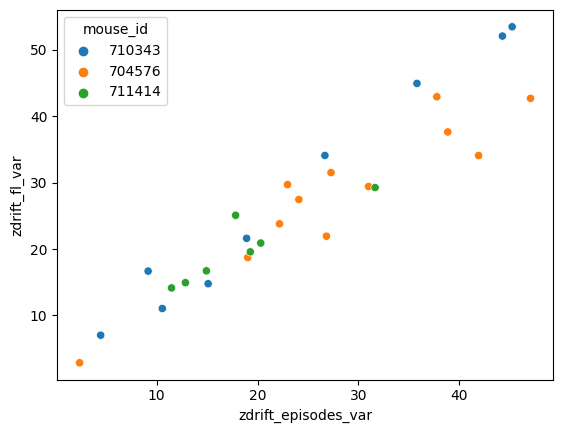

In [99]:
sns.scatterplot(session_table, x='zdrift_episodes_var', y='zdrift_fl_var', hue='mouse_id')

Text(0.5, 0, 'Water (ml)')

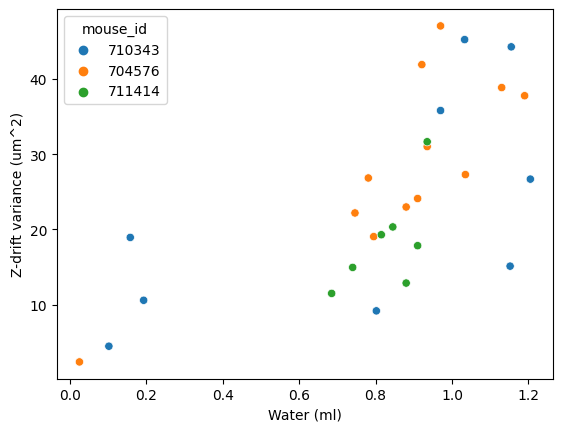

In [17]:
fig, ax = plt.subplots()
sns.scatterplot(session_table, x='water', y='zdrift_episodes_var', hue='mouse_id', ax=ax)
ax.set_ylabel('Z-drift variance (um^2)')
ax.set_xlabel('Water (ml)')

Text(0.5, 0, 'Water (ml)')

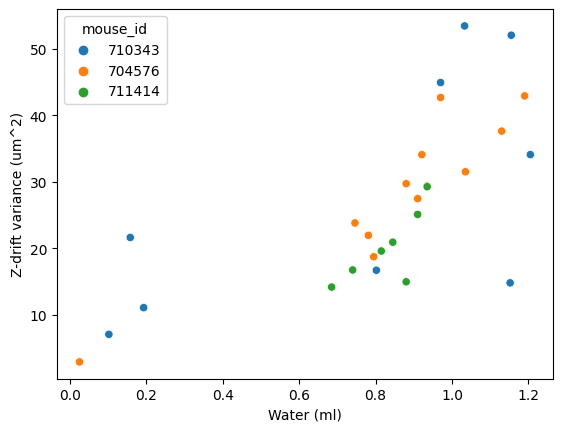

In [18]:
fig, ax = plt.subplots()
sns.scatterplot(session_table, x='water', y='zdrift_fl_var', hue='mouse_id', ax=ax)
ax.set_ylabel('Z-drift variance (um^2)')
ax.set_xlabel('Water (ml)')

## 2x4 examples
- Divide into VISp and VISam

In [25]:
lamf_table.config.unique()

array(['2x4', '1x8'], dtype=object)

In [100]:
visp_table = lamf_table.query('config=="2x4" and region=="VISp"').copy()
visp_table.reset_index(drop=False, inplace=True)

visp_table = visp_table.merge(visp_table.groupby('ophys_session_id')['zdrift_episodes'].var(),
                          left_on='ophys_session_id',
                          right_on='ophys_session_id',
                          suffixes=('', '_var'))
visp_table = visp_table.merge(visp_table.groupby('ophys_session_id')['zdrift_fl'].var(),
                          left_on='ophys_session_id',
                          right_on='ophys_session_id',
                          suffixes=('', '_var')).set_index('oeid', drop=True)

cc_threshold = 0.7
cc_session_table = visp_table.groupby('ophys_session_id').apply(lambda x: (x.min_cc_fl.min() >= cc_threshold) and (x.min_cc_episodes.min() >= cc_threshold))
osids = cc_session_table.index[cc_session_table]
cc_table = visp_table.query('ophys_session_id in @osids').reset_index(drop=False)
print(len(osids))


61


In [101]:
session_table = cc_table.set_index('ophys_session_id')[['mouse_id', 'water', 'zdrift_fl_var', 'zdrift_episodes_var']].drop_duplicates()

<AxesSubplot:xlabel='zdrift_episodes_var', ylabel='zdrift_fl_var'>

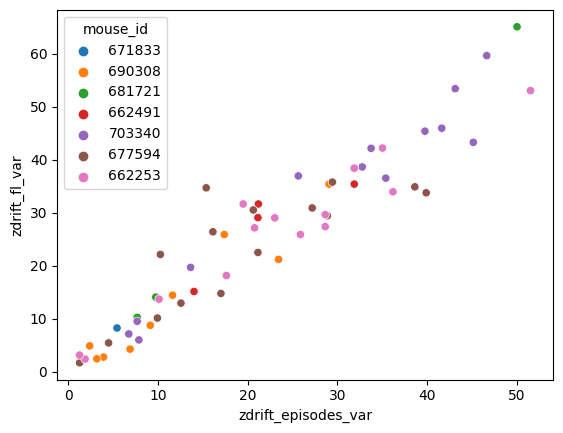

In [102]:
sns.scatterplot(session_table, x='zdrift_episodes_var', y='zdrift_fl_var', hue='mouse_id')

Text(0.5, 1.0, '2x4, VISp (GAD2-Cre)')

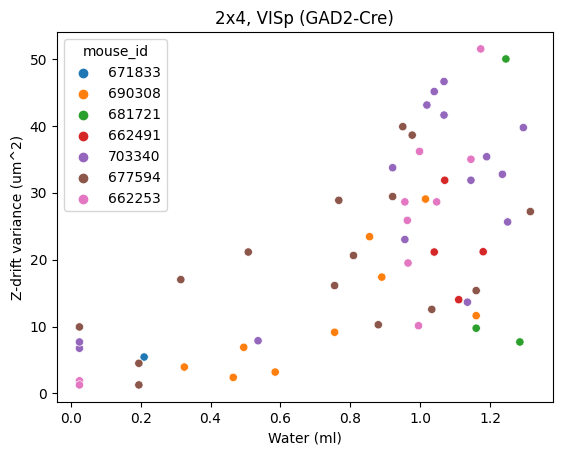

In [103]:
fig, ax = plt.subplots()
sns.scatterplot(session_table, x='water', y='zdrift_episodes_var', hue='mouse_id', ax=ax)
ax.set_ylabel('Z-drift variance (um^2)')
ax.set_xlabel('Water (ml)')
ax.set_title('2x4, VISp (GAD2-Cre)')

Text(0.5, 1.0, '2x4, VISp (GAD2-Cre)')

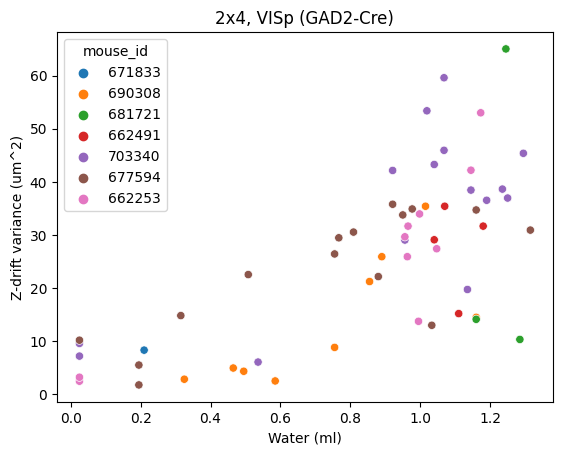

In [104]:
fig, ax = plt.subplots()
sns.scatterplot(session_table, x='water', y='zdrift_fl_var', hue='mouse_id', ax=ax)
ax.set_ylabel('Z-drift variance (um^2)')
ax.set_xlabel('Water (ml)')
ax.set_title('2x4, VISp (GAD2-Cre)')

In [105]:
visam_table = lamf_table.query('config=="2x4" and region=="VISam"').copy()
visam_table.reset_index(drop=False, inplace=True)

visam_table = visam_table.merge(visam_table.groupby('ophys_session_id')['zdrift_episodes'].var(),
                          left_on='ophys_session_id',
                          right_on='ophys_session_id',
                          suffixes=('', '_var'))
visam_table = visam_table.merge(visam_table.groupby('ophys_session_id')['zdrift_fl'].var(),
                          left_on='ophys_session_id',
                          right_on='ophys_session_id',
                          suffixes=('', '_var')).set_index('oeid', drop=True)


cc_threshold = 0.7
cc_session_table = visam_table.groupby('ophys_session_id').apply(lambda x: (x.min_cc_fl.min() >= cc_threshold) and (x.min_cc_episodes.min() >= cc_threshold))
osids = cc_session_table.index[cc_session_table]
cc_table = visam_table.query('ophys_session_id in @osids').reset_index(drop=False)
print(len(osids))

74


<AxesSubplot:xlabel='zdrift_episodes_var', ylabel='zdrift_fl_var'>

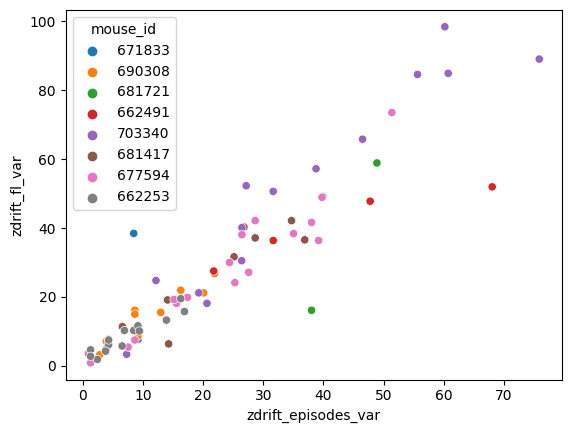

In [111]:
session_table = cc_table.set_index('ophys_session_id')[['mouse_id', 'water', 'zdrift_fl_var', 'zdrift_episodes_var']].drop_duplicates()
sns.scatterplot(session_table, x='zdrift_episodes_var', y='zdrift_fl_var', hue='mouse_id')

Text(0.5, 1.0, '2x4, VISam (GAD2-Cre)')

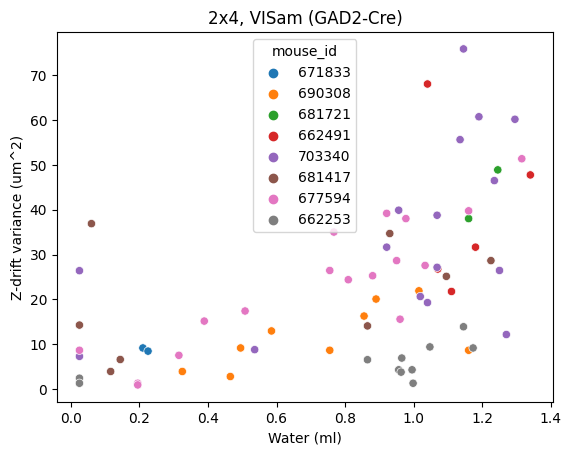

In [107]:
fig, ax = plt.subplots()
sns.scatterplot(session_table, x='water', y='zdrift_episodes_var', hue='mouse_id', ax=ax)
ax.set_ylabel('Z-drift variance (um^2)')
ax.set_xlabel('Water (ml)')
ax.set_title('2x4, VISam (GAD2-Cre)')

Text(0.5, 1.0, '2x4, VISam (GAD2-Cre)')

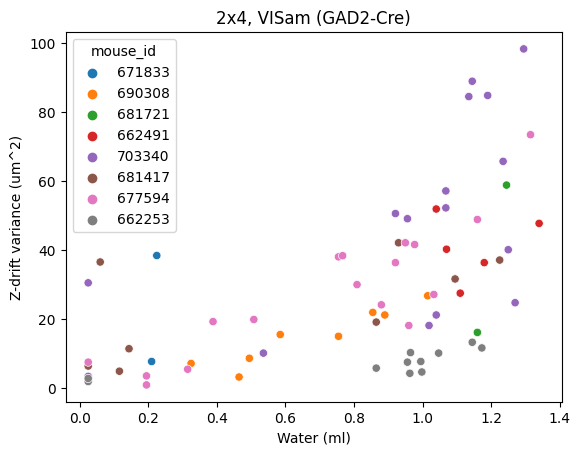

In [108]:
fig, ax = plt.subplots()
sns.scatterplot(session_table, x='water', y='zdrift_fl_var', hue='mouse_id', ax=ax)
ax.set_ylabel('Z-drift variance (um^2)')
ax.set_xlabel('Water (ml)')
ax.set_title('2x4, VISam (GAD2-Cre)')

In [109]:
# checkout some sessions of high z-drift without water
session_table.query('water < 0.3 and zdrift_episodes_var > 20')

,mouse_id,water,zdrift_fl_var,zdrift_episodes_var
ophys_session_id,,,,
1319380616,703340,0.025,30.515625,26.390625
1286777141,681417,0.060,36.562500,36.890625


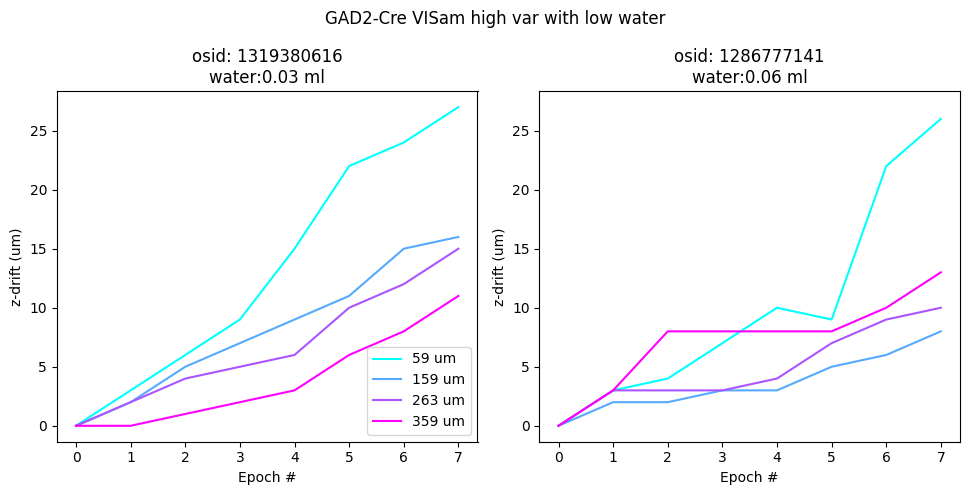

In [114]:
osids = [1319380616, 1286777141]
fig, ax = plt.subplots(1, len(osids), figsize=(5*len(osids), 5))
y_max = 0
y_min = 0
import matplotlib as mpl
colors = mpl.cm.get_cmap('cool')
for i, osid in enumerate(osids):
    temp_table = cc_table.query('ophys_session_id== @osid').sort_values(by='imaging_depth')
    water = temp_table.water.unique()[0]
    num_planes = len(temp_table)
    for ii, oeid in enumerate(temp_table.index):
        zdrift = temp_table.loc[oeid, 'mpi_episodes']
        zdrift = zdrift - zdrift[0]
        ax[i].plot(range(len(zdrift)), zdrift,
                   color=colors(ii/(num_planes-1)),
                   label=f'{int(temp_table.loc[oeid, "imaging_depth"])} um')
    ax[i].set_title(f'osid: {osid}\nwater:{water:.2f} ml')
    ax[i].set_xlabel('Epoch #')
    ax[i].set_ylabel('z-drift (um)')
    y_max = max(y_max, ax[i].get_ylim()[1])
    y_min = min(y_min, ax[i].get_ylim()[0])
ax[0].legend(loc='lower right')
for i in range(len(osids)):
    ax[i].set_ylim(y_min, y_max)
    # ax[i].invert_yaxis()
fig.suptitle(f'GAD2-Cre VISam high var with low water')
fig.tight_layout(rect=[0, 0, 0.98, 1])

# Other visual behavior data
- Passive sessions and OPHYS7 got water before the session, so exclude them
- From 240325_multiplane_zdrift_comparison_other_lines.ipynb

In [175]:
vbm_table_fn = zdrift_dir / 'multiplane_zdrift_vbm.pkl'
vbm_table = pd.read_pickle(vbm_table_fn)
bad_imaging_sessions = [977760370, 1081070236, 1075872563, 906968227,
                        1088200327, 884613038, 921636320, 876303107,
                        923705570, 865024413, 958105827, 976167513, 981845703]
filtered_table = vbm_table[~vbm_table.ophys_session_id.isin(bad_imaging_sessions)]
vbm_table = filtered_table[~filtered_table.session_type.str.contains('passive') &
                              ~filtered_table.session_type.str.contains('OPHYS_7')].copy()
# add mouse IDs
vbm_table.set_index('oeid', inplace=True)
vbm_table['mouse_id'] = vbm_table.index.map(lambda x: table.loc[x].mouse_id)
vbm_table.reset_index(drop=False, inplace=True)

vbm_table['min_cc_episodes'] = vbm_table.apply(lambda x: np.min([x['cc_episodes'][0], x['cc_episodes'][-1]]), axis=1)
vbm_table['min_cc_fl'] = vbm_table.apply(lambda x: np.min(x.cc_fl), axis=1)
vbm_table['zdrift_episodes'] = vbm_table.apply(lambda x: plane_interval * (x.mpi_episodes[-1] - x.mpi_episodes[0]), axis=1)
vbm_table['zdrift_fl'] = vbm_table.apply(lambda x: plane_interval * (x.mpi_fl[1] - x.mpi_fl[0]), axis=1)


C:\Users\jinho.kim\AppData\Roaming\Python\Python38\site-packages\pandas\core\indexes\base.py:6999: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)


In [66]:
vbm_table.groupby('full_genotype').apply(lambda x: len(x.mouse_id.unique()))



full_genotype
Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-GCaMP6f)/wt    11
Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt                9
Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt               11
dtype: int64

In [67]:
vbm_table.groupby('full_genotype').apply(lambda x: len(x.osid.unique()))

full_genotype
Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-GCaMP6f)/wt    53
Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt               41
Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt               49
dtype: int64

Text(0.5, 0.98, 'Visual behavior (water)')

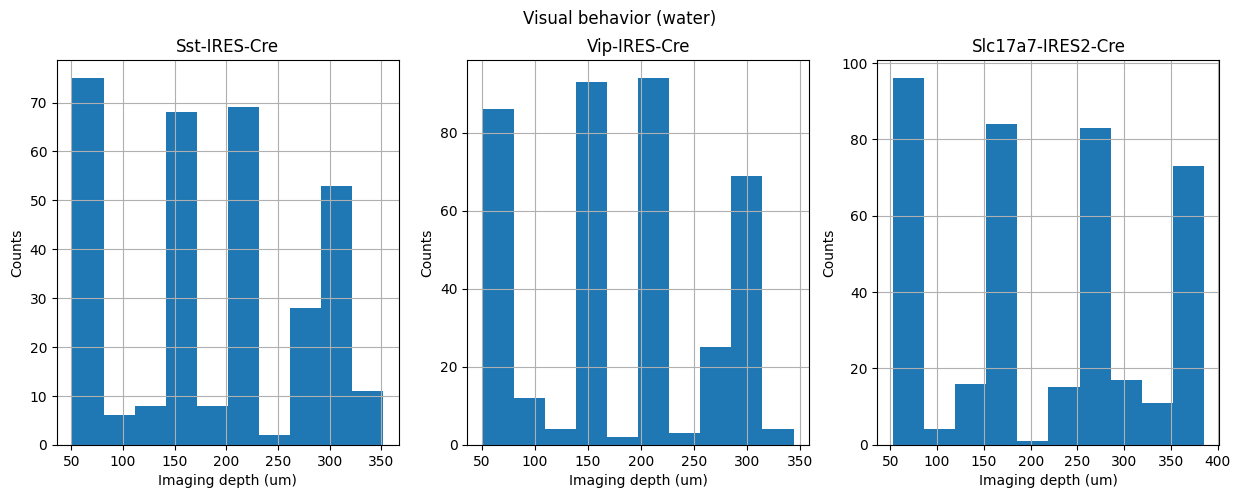

In [84]:
cre_lines = vbm_table.cre_line.unique()
fig, ax = plt.subplots(1, len(cre_lines), figsize=(5*len(cre_lines), 5))
for ci, cre_line in enumerate(cre_lines):
    vbm_table.query('cre_line==@cre_line').imaging_depth.hist(ax=ax[ci])
    ax[ci].set_xlabel('Imaging depth (um)')
    ax[ci].set_ylabel('Counts')
    ax[ci].set_title(cre_line)
fig.suptitle('Visual behavior (water)')

## Slc17a7
- VISp and VISl

In [116]:
exc_visp_table = vbm_table[vbm_table.cre_line.str.contains('Slc17a7') &
                            (vbm_table.region=='VISp')].copy()


exc_visp_table = exc_visp_table.merge(exc_visp_table.groupby('ophys_session_id')['zdrift_episodes'].var(),
                          left_on='ophys_session_id',
                          right_on='ophys_session_id',
                          suffixes=('', '_var'))
exc_visp_table = exc_visp_table.merge(exc_visp_table.groupby('ophys_session_id')['zdrift_fl'].var(),
                          left_on='ophys_session_id',
                          right_on='ophys_session_id',
                          suffixes=('', '_var')).set_index('oeid', drop=True)

cc_threshold = 0.7
cc_session_table = exc_visp_table.groupby('ophys_session_id').apply(lambda x: (x.min_cc_fl.min() >= cc_threshold) and (x.min_cc_episodes.min() >= cc_threshold))
osids = cc_session_table.index[cc_session_table]
cc_table = exc_visp_table.query('ophys_session_id in @osids').reset_index(drop=False)
print(len(osids))

47


<AxesSubplot:xlabel='zdrift_episodes_var', ylabel='zdrift_fl_var'>

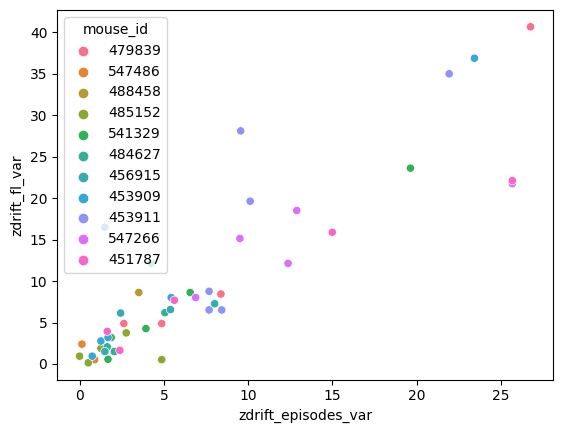

In [117]:
session_table = cc_table.set_index('ophys_session_id')[['mouse_id', 'water', 'zdrift_fl_var', 'zdrift_episodes_var']].drop_duplicates()
sns.scatterplot(session_table, x='zdrift_episodes_var', y='zdrift_fl_var', hue='mouse_id')

In [118]:
# checkout sessions with large difference between episodes var and fl var
session_table[session_table.zdrift_fl_var.values - session_table.zdrift_episodes_var.values > 10]

,mouse_id,water,zdrift_fl_var,zdrift_episodes_var
ophys_session_id,,,,
985609503,479839,0.858,40.687500,26.765625
931687751,453909,0.494,36.890625,23.437500
914728054,453909,0.298,16.500000,1.500000
906299056,453911,1.159,35.015625,21.937500
908441202,453911,1.292,28.125000,9.562500


In [119]:
osids = [1088200327, 884613038, 921636320]
check_table = cc_table.query('ophys_session_id in @osids')
check_table

,oeid,depth,region,mpi_episodes,cc_episodes,mpi_fl,cc_fl,osid,ophys_experiment_id,equipment_name,...,session_type,config,water,mouse_id,min_cc_episodes,min_cc_fl,zdrift_episodes,zdrift_fl,zdrift_episodes_var,zdrift_fl_var


In [82]:
oeid = 1088351115
ocid = from_lims.get_ophys_container_id_for_ophys_experiment_id(oeid)
zdrift_fn = zdrift_dir / f'container_{ocid}' / f'experiment_{oeid}' / f'{oeid}_zdrift_ref_{oeid}.h5'
print(zdrift_fn.parent)

\\allen\programs\mindscope\workgroups\learning\ophys\zdrift\container_1084230240\experiment_1088351115


In [81]:
osids

[1088200327, 884613038, 921636320]

### Add these sessions to bad imaging sessions

In [58]:
# checkout sessions with huge variance
osids = session_table.query('zdrift_episodes_var > 50').index.values
check_table = cc_table.query('ophys_session_id in @osids')
check_table

,oeid,depth,region,mpi_episodes,cc_episodes,mpi_fl,cc_fl,osid,ophys_experiment_id,equipment_name,...,session_type,config,water,mouse_id,min_cc_episodes,min_cc_fl,zdrift_episodes,zdrift_fl,zdrift_episodes_var,zdrift_fl_var
60,1076261142,375,VISp,"[41, 41, 39, 40, 39, 37, 37, 35]","[0.835329959873061, 0.846103164884539, 0.85033...","[42, 35]","[0.7730704960504348, 0.7942151172090328]",1075872563,1076261142,MESO.1,...,OPHYS_1_images_A,2x4,0.536,541329,0.835330,0.773070,-4.50,-5.25,214.834821,212.293527
61,1076261140,75,VISp,"[78, 78, 78, 78, 72, 71, 72, 78]","[0.8216236005682589, 0.8307642918156526, 0.863...","[78, 77]","[0.7996810875161573, 0.8698677323315932]",1075872563,1076261140,MESO.1,...,OPHYS_1_images_A,2x4,0.536,541329,0.821624,0.799681,0.00,-0.75,214.834821,212.293527
62,1076261139,275,VISp,"[39, 39, 39, 39, 40, 39, 39, 38]","[0.926328624132749, 0.9284932277605029, 0.9318...","[39, 38]","[0.8376133244846584, 0.9457419842422193]",1075872563,1076261139,MESO.1,...,OPHYS_1_images_A,2x4,0.536,541329,0.926329,0.837613,-0.75,-0.75,214.834821,212.293527
63,1076261137,175,VISp,"[76, 78, 78, 63, 54, 46, 47, 45]","[0.9105768400323153, 0.9164778093316648, 0.937...","[75, 43]","[0.9010253101421699, 0.9775618326153598]",1075872563,1076261137,MESO.1,...,OPHYS_1_images_A,2x4,0.536,541329,0.910577,0.901025,-23.25,-24.00,214.834821,212.293527
140,907694954,79,VISp,"[23, 25, 27, 29, 31, 34, 37, 37]","[0.8773673502525446, 0.8914702103542319, 0.916...","[22, 38]","[0.8605887119466255, 0.9693386549888962]",906968227,907694954,MESO.1,...,OPHYS_4_images_B,2x4,0.914,453911,0.877367,0.860589,10.50,12.00,152.156250,200.159598
141,907694952,375,VISp,"[75, 17, 18, 36, 36, 36, 47, 47]","[0.8243978452257577, 0.8451660064527006, 0.864...","[77, 43]","[0.781861928392082, 0.8656893847926406]",906968227,907694952,MESO.1,...,OPHYS_4_images_B,2x4,0.914,453911,0.824398,0.781862,-21.00,-25.50,152.156250,200.159598
142,907694950,169,VISp,"[24, 27, 29, 30, 31, 34, 37, 37]","[0.9018122269317784, 0.9079647993429718, 0.938...","[24, 37]","[0.8893536088140044, 0.9751236399829314]",906968227,907694950,MESO.1,...,OPHYS_4_images_B,2x4,0.914,453911,0.901812,0.889354,9.75,9.75,152.156250,200.159598
143,907694948,273,VISp,"[26, 27, 27, 27, 27, 29, 29, 29]","[0.8670819727264971, 0.8870090976598677, 0.911...","[26, 30]","[0.8260196897562875, 0.9181701486372668]",906968227,907694948,MESO.1,...,OPHYS_4_images_B,2x4,0.914,453911,0.867082,0.826020,2.25,3.00,152.156250,200.159598


In [60]:
oeid = 907694952
ocid = from_lims.get_ophys_container_id_for_ophys_experiment_id(oeid)
zdrift_fn = zdrift_dir / f'container_{ocid}' / f'experiment_{oeid}' / f'{oeid}_zdrift_ref_{oeid}.h5'
print(zdrift_fn.parent)

\\allen\programs\mindscope\workgroups\learning\ophys\zdrift\container_1018027884\experiment_907694952


In [61]:
osids

array([1075872563,  906968227], dtype=int64)

Text(0.5, 1.0, '2x4, VISp (Slc17a7-Cre)')

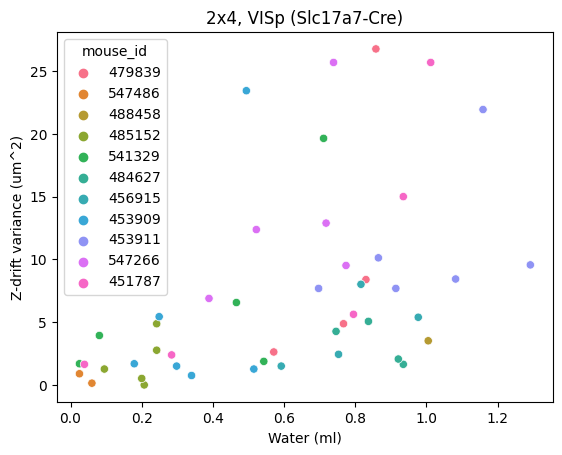

In [120]:
fig, ax = plt.subplots()
sns.scatterplot(session_table, x='water', y='zdrift_episodes_var', hue='mouse_id', ax=ax)
ax.set_ylabel('Z-drift variance (um^2)')
ax.set_xlabel('Water (ml)')
ax.set_title('2x4, VISp (Slc17a7-Cre)')

Text(0.5, 1.0, '2x4, VISp (Slc17a7-Cre)')

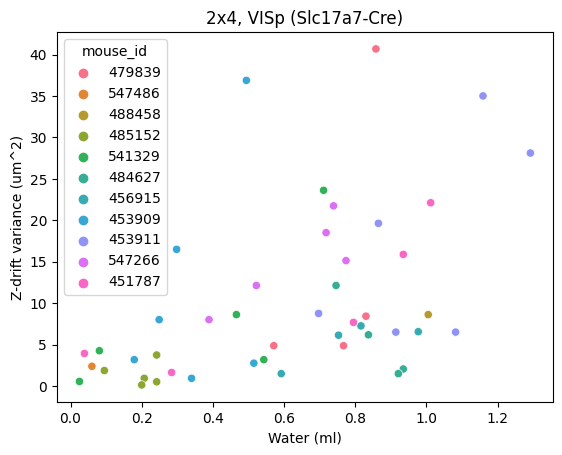

In [121]:
fig, ax = plt.subplots()
sns.scatterplot(session_table, x='water', y='zdrift_fl_var', hue='mouse_id', ax=ax)
ax.set_ylabel('Z-drift variance (um^2)')
ax.set_xlabel('Water (ml)')
ax.set_title('2x4, VISp (Slc17a7-Cre)')

In [122]:
exc_visl_table = vbm_table[vbm_table.cre_line.str.contains('Slc17a7') &
                            (vbm_table.region=='VISl')]
exc_visl_table = exc_visl_table.merge(exc_visl_table.groupby('ophys_session_id')['zdrift_episodes'].var(),
                          left_on='ophys_session_id',
                          right_on='ophys_session_id',
                          suffixes=('', '_var'))
exc_visl_table = exc_visl_table.merge(exc_visl_table.groupby('ophys_session_id')['zdrift_fl'].var(),
                          left_on='ophys_session_id',
                          right_on='ophys_session_id',
                          suffixes=('', '_var')).set_index('oeid', drop=True)

cc_threshold = 0.7
cc_session_table = exc_visl_table.groupby('ophys_session_id').apply(lambda x: (x.min_cc_fl.min() >= cc_threshold) and (x.min_cc_episodes.min() >= cc_threshold))
osids = cc_session_table.index[cc_session_table]
cc_table = exc_visl_table.query('ophys_session_id in @osids').reset_index(drop=False)
print(len(osids))

46


<AxesSubplot:xlabel='zdrift_episodes_var', ylabel='zdrift_fl_var'>

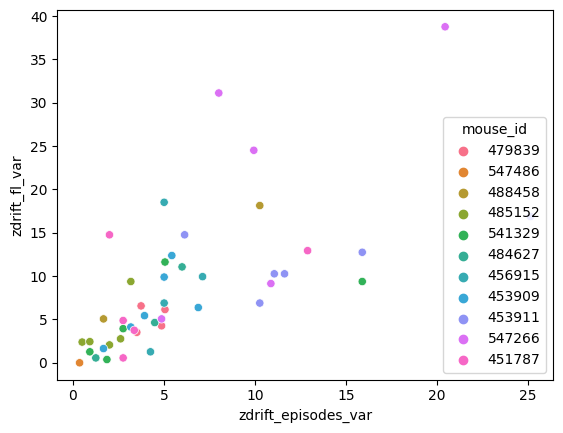

In [123]:
session_table = cc_table.set_index('ophys_session_id')[['mouse_id', 'water', 'zdrift_fl_var', 'zdrift_episodes_var']].drop_duplicates()
sns.scatterplot(session_table, x='zdrift_episodes_var', y='zdrift_fl_var', hue='mouse_id')

Text(0.5, 1.0, '2x4, VISl (Slc17a7-Cre)')

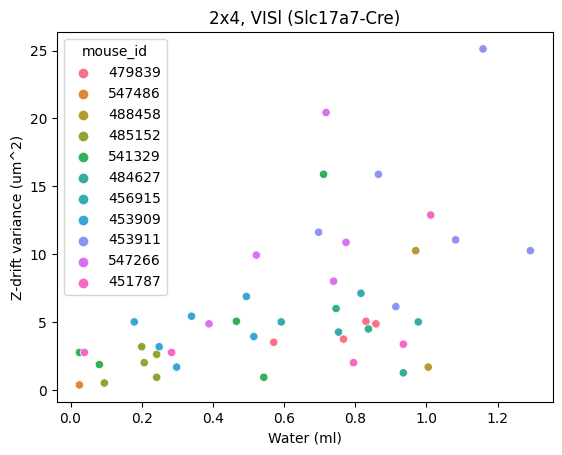

In [124]:
fig, ax = plt.subplots()
sns.scatterplot(session_table, x='water', y='zdrift_episodes_var', hue='mouse_id', ax=ax)
ax.set_ylabel('Z-drift variance (um^2)')
ax.set_xlabel('Water (ml)')
ax.set_title('2x4, VISl (Slc17a7-Cre)')

Text(0.5, 1.0, '2x4, VISl (Slc17a7-Cre)')

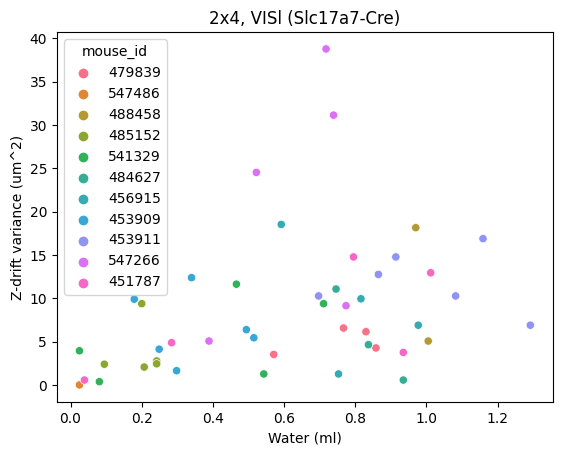

In [125]:
fig, ax = plt.subplots()
sns.scatterplot(session_table, x='water', y='zdrift_fl_var', hue='mouse_id', ax=ax)
ax.set_ylabel('Z-drift variance (um^2)')
ax.set_xlabel('Water (ml)')
ax.set_title('2x4, VISl (Slc17a7-Cre)')

## VIP

In [136]:
vip_visp_table = vbm_table[vbm_table.cre_line.str.contains('Vip') &
                            (vbm_table.region=='VISp')]
vip_visp_table = vip_visp_table.merge(vip_visp_table.groupby('ophys_session_id')['zdrift_episodes'].var(),
                          left_on='ophys_session_id',
                          right_on='ophys_session_id',
                          suffixes=('', '_var'))
vip_visp_table = vip_visp_table.merge(vip_visp_table.groupby('ophys_session_id')['zdrift_fl'].var(),
                          left_on='ophys_session_id',
                          right_on='ophys_session_id',
                          suffixes=('', '_var')).set_index('oeid', drop=True)

cc_threshold = 0.7
cc_session_table = vip_visp_table.groupby('ophys_session_id').apply(lambda x: (x.min_cc_fl.min() >= cc_threshold) and (x.min_cc_episodes.min() >= cc_threshold))
osids = cc_session_table.index[cc_session_table]
cc_table = vip_visp_table.query('ophys_session_id in @osids').reset_index(drop=False)
print(len(osids))

26


<AxesSubplot:xlabel='zdrift_episodes_var', ylabel='zdrift_fl_var'>

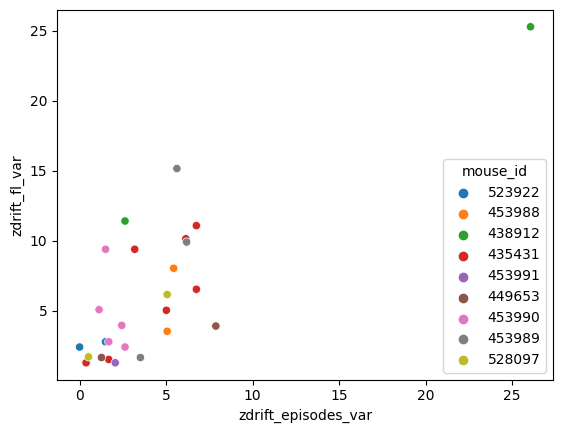

In [137]:
session_table = cc_table.set_index('ophys_session_id')[['mouse_id', 'water', 'zdrift_fl_var', 'zdrift_episodes_var']].drop_duplicates()
sns.scatterplot(session_table, x='zdrift_episodes_var', y='zdrift_fl_var', hue='mouse_id')

In [129]:
# checkout sessions with large difference between episodes var and fl var
session_table[abs(session_table.zdrift_fl_var.values - session_table.zdrift_episodes_var.values) > 10]

,mouse_id,water,zdrift_fl_var,zdrift_episodes_var
ophys_session_id,,,,
876303107,449653,0.872,14.765625,26.0625
923705570,453990,0.557,21.515625,1.8750


In [130]:
osids = [876303107, 923705570]
check_table = cc_table.query('ophys_session_id in @osids')
check_table

,oeid,depth,region,mpi_episodes,cc_episodes,mpi_fl,cc_fl,osid,ophys_experiment_id,equipment_name,...,session_type,config,water,mouse_id,min_cc_episodes,min_cc_fl,zdrift_episodes,zdrift_fl,zdrift_episodes_var,zdrift_fl_var
56,877057338,150,VISp,"[32, 34, 35, 36, 37, 37, 38, 38]","[0.8894373691528786, 0.8885479772464612, 0.902...","[31, 39]","[0.8879808279890133, 0.8906621999174004]",876303107,877057338,MESO.1,...,OPHYS_4_images_B,2x4,0.872,449653,0.889437,0.887981,4.50,6.00,26.0625,14.765625
57,877057344,81,VISp,"[27, 29, 30, 31, 33, 35, 37, 39]","[0.903446783888116, 0.8835774956501891, 0.8942...","[28, 40]","[0.9241805055009714, 0.8642750191602772]",876303107,877057344,MESO.1,...,OPHYS_4_images_B,2x4,0.872,449653,0.898009,0.864275,9.00,9.00,26.0625,14.765625
58,877057341,300,VISp,"[42, 42, 42, 41, 40, 40, 38, 40]","[0.776494795803887, 0.7925347975993305, 0.7929...","[32, 41]","[0.7758901360697762, 0.8362090529473856]",876303107,877057341,MESO.1,...,OPHYS_4_images_B,2x4,0.872,449653,0.776495,0.775890,-1.50,6.75,26.0625,14.765625
59,877057336,225,VISp,"[40, 40, 40, 41, 41, 40, 39, 38]","[0.9219246309973622, 0.9099607641649803, 0.920...","[40, 40]","[0.9055357290469387, 0.9112054235642045]",876303107,877057336,MESO.1,...,OPHYS_4_images_B,2x4,0.872,449653,0.921925,0.905536,-1.50,0.00,26.0625,14.765625
88,924198887,292,VISp,"[31, 31, 31, 31, 32, 31, 32, 31]","[0.8353890300923743, 0.8282824941112001, 0.832...","[40, 31]","[0.8604485190558487, 0.818333948292123]",923705570,924198887,MESO.1,...,OPHYS_6_images_B,2x4,0.557,453990,0.833712,0.818334,0.00,-6.75,1.8750,21.515625
89,924198889,83,VISp,"[35, 35, 36, 36, 37, 38, 39, 39]","[0.9102971024885481, 0.9112255225369815, 0.890...","[33, 38]","[0.9244176734439948, 0.8430447629302561]",923705570,924198889,MESO.1,...,OPHYS_6_images_B,2x4,0.557,453990,0.866339,0.843045,3.00,3.75,1.8750,21.515625
90,924198885,150,VISp,"[34, 35, 35, 35, 36, 37, 37, 37]","[0.9278529578576153, 0.9226320928608902, 0.913...","[34, 37]","[0.9123442698471876, 0.9043097318273244]",923705570,924198885,MESO.1,...,OPHYS_6_images_B,2x4,0.557,453990,0.914837,0.904310,2.25,2.25,1.8750,21.515625
91,924198883,221,VISp,"[33, 34, 34, 34, 34, 35, 38, 34]","[0.9577725256086951, 0.9581557178472636, 0.952...","[34, 34]","[0.9422819414349849, 0.9424690518019867]",923705570,924198883,MESO.1,...,OPHYS_6_images_B,2x4,0.557,453990,0.957660,0.942282,0.75,0.00,1.8750,21.515625


In [133]:
oeid = 924198887
ocid = from_lims.get_ophys_container_id_for_ophys_experiment_id(oeid)
zdrift_fn = zdrift_dir / f'container_{ocid}' / f'experiment_{oeid}' / f'{oeid}_zdrift_ref_{oeid}.h5'
print(zdrift_fn.parent)

\\allen\programs\mindscope\workgroups\learning\ophys\zdrift\container_1018028176\experiment_924198887


In [134]:
osids

[876303107, 923705570]

Text(0.5, 1.0, '2x4, VISp (VIP-Cre)')

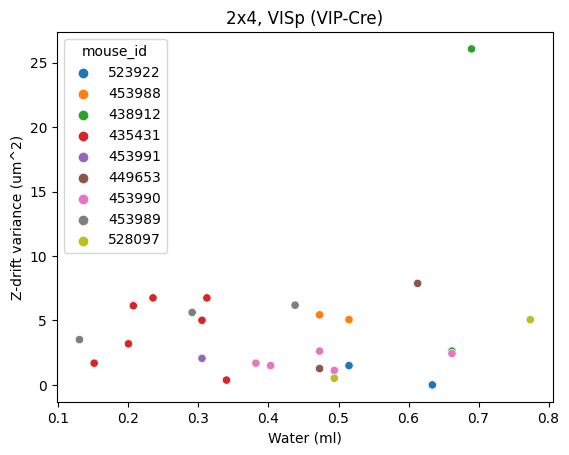

In [139]:
fig, ax = plt.subplots()
sns.scatterplot(session_table, x='water', y='zdrift_episodes_var', hue='mouse_id', ax=ax)
ax.set_ylabel('Z-drift variance (um^2)')
ax.set_xlabel('Water (ml)')
ax.set_title('2x4, VISp (VIP-Cre)')

Text(0.5, 1.0, '2x4, VISp (VIP-Cre)')

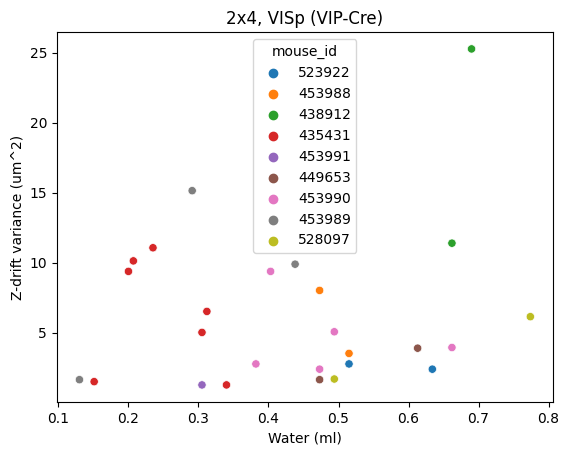

In [140]:
fig, ax = plt.subplots()
sns.scatterplot(session_table, x='water', y='zdrift_fl_var', hue='mouse_id', ax=ax)
ax.set_ylabel('Z-drift variance (um^2)')
ax.set_xlabel('Water (ml)')
ax.set_title('2x4, VISp (VIP-Cre)')

In [141]:
vip_visl_table = vbm_table[vbm_table.cre_line.str.contains('Vip') &
                            (vbm_table.region=='VISl')]
vip_visl_table = vip_visl_table.merge(vip_visl_table.groupby('ophys_session_id')['zdrift_episodes'].var(),
                          left_on='ophys_session_id',
                          right_on='ophys_session_id',
                          suffixes=('', '_var'))
vip_visl_table = vip_visl_table.merge(vip_visl_table.groupby('ophys_session_id')['zdrift_fl'].var(),
                          left_on='ophys_session_id',
                          right_on='ophys_session_id',
                          suffixes=('', '_var')).set_index('oeid', drop=True)

cc_threshold = 0.7
cc_session_table = vip_visl_table.groupby('ophys_session_id').apply(lambda x: (x.min_cc_fl.min() >= cc_threshold) and (x.min_cc_episodes.min() >= cc_threshold))
osids = cc_session_table.index[cc_session_table]
cc_table = vip_visl_table.query('ophys_session_id in @osids').reset_index(drop=False)
print(len(osids))

30


<AxesSubplot:xlabel='zdrift_episodes_var', ylabel='zdrift_fl_var'>

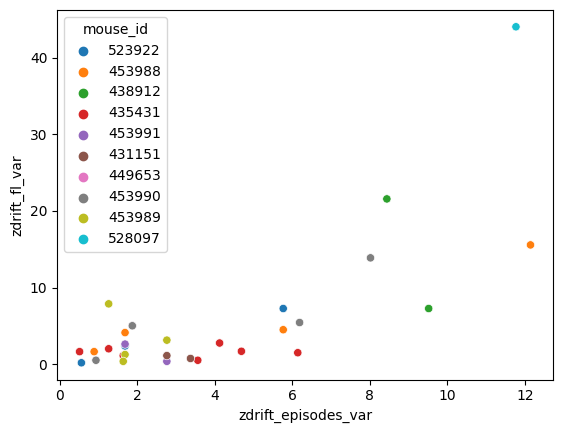

In [143]:
session_table = cc_table.set_index('ophys_session_id')[['mouse_id', 'water', 'zdrift_fl_var', 'zdrift_episodes_var']].drop_duplicates()
sns.scatterplot(session_table, x='zdrift_episodes_var', y='zdrift_fl_var', hue='mouse_id')

Text(0.5, 1.0, '2x4, VISl (VIP-Cre)')

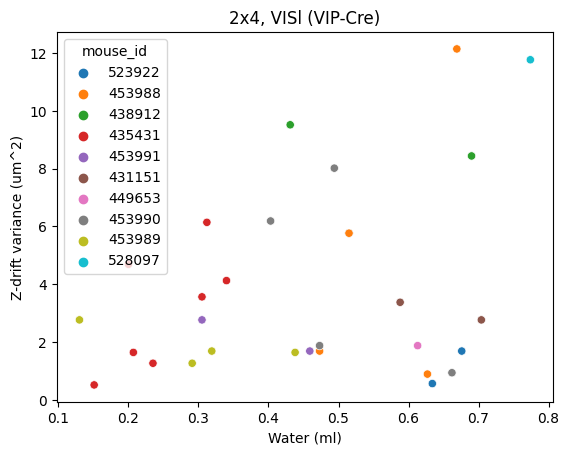

In [144]:
fig, ax = plt.subplots()
sns.scatterplot(session_table, x='water', y='zdrift_episodes_var', hue='mouse_id', ax=ax)
ax.set_ylabel('Z-drift variance (um^2)')
ax.set_xlabel('Water (ml)')
ax.set_title('2x4, VISl (VIP-Cre)')

Text(0.5, 1.0, '2x4, VISl (VIP-Cre)')

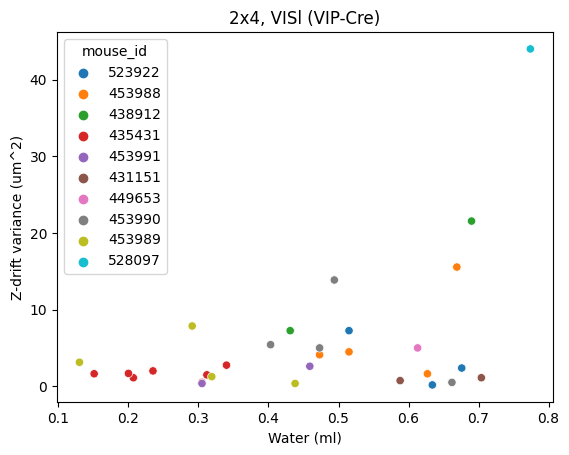

In [145]:
fig, ax = plt.subplots()
sns.scatterplot(session_table, x='water', y='zdrift_fl_var', hue='mouse_id', ax=ax)
ax.set_ylabel('Z-drift variance (um^2)')
ax.set_xlabel('Water (ml)')
ax.set_title('2x4, VISl (VIP-Cre)')

## SST-Cre

In [165]:
sst_visp_table = vbm_table[vbm_table.cre_line.str.contains('Sst') &
                            (vbm_table.region=='VISp')]
sst_visp_table = sst_visp_table.merge(sst_visp_table.groupby('ophys_session_id')['zdrift_episodes'].var(),
                          left_on='ophys_session_id',
                          right_on='ophys_session_id',
                          suffixes=('', '_var'))
sst_visp_table = sst_visp_table.merge(sst_visp_table.groupby('ophys_session_id')['zdrift_fl'].var(),
                          left_on='ophys_session_id',
                          right_on='ophys_session_id',
                          suffixes=('', '_var')).set_index('oeid', drop=True)

cc_threshold = 0.7
cc_session_table = sst_visp_table.groupby('ophys_session_id').apply(lambda x: (x.min_cc_fl.min() >= cc_threshold) and (x.min_cc_episodes.min() >= cc_threshold))
osids = cc_session_table.index[cc_session_table]
cc_table = sst_visp_table.query('ophys_session_id in @osids').reset_index(drop=False)
print(len(osids))

12


<AxesSubplot:xlabel='zdrift_episodes_var', ylabel='zdrift_fl_var'>

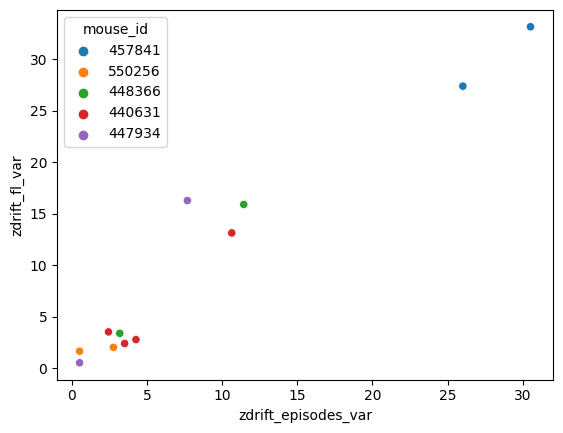

In [166]:
session_table = cc_table.set_index('ophys_session_id')[['mouse_id', 'water', 'zdrift_fl_var', 'zdrift_episodes_var']].drop_duplicates()
sns.scatterplot(session_table, x='zdrift_episodes_var', y='zdrift_fl_var', hue='mouse_id')

In [148]:
# checkout sessions with large difference between episodes var and fl var
session_table[abs(session_table.zdrift_fl_var.values - session_table.zdrift_episodes_var.values) > 10]

,mouse_id,water,zdrift_fl_var,zdrift_episodes_var
ophys_session_id,,,,
958105827,457841,0.340,80.390625,70.125000
865024413,447934,0.032,409.640625,2.765625


In [156]:
osids = [865024413, 958105827]
check_table = cc_table.query('ophys_session_id in @osids')
check_table

,oeid,depth,region,mpi_episodes,cc_episodes,mpi_fl,cc_fl,osid,ophys_experiment_id,equipment_name,...,session_type,config,water,mouse_id,min_cc_episodes,min_cc_fl,zdrift_episodes,zdrift_fl,zdrift_episodes_var,zdrift_fl_var
8,958741226,300,VISp,"[17, 18, 18, 19, 35, 40, 40, 41]","[0.7533982583650352, 0.7450674187380812, 0.754...","[17, 41]","[0.7410722646272294, 0.8181897332094232]",958105827,958741226,MESO.1,...,OPHYS_3_images_A,2x4,0.34,457841,0.753398,0.741072,18.00,18.00,70.125,80.390625
9,958741224,75,VISp,"[23, 25, 25, 33, 39, 42, 42, 42]","[0.7483373806679211, 0.7231364019969665, 0.701...","[23, 43]","[0.7432064463961147, 0.7146860870249431]",958105827,958741224,MESO.1,...,OPHYS_3_images_A,2x4,0.34,457841,0.731659,0.714686,14.25,15.00,70.125,80.390625
10,958741222,225,VISp,"[32, 34, 34, 34, 35, 35, 36, 35]","[0.8933729446143032, 0.8976928575709312, 0.905...","[33, 35]","[0.8627717384622312, 0.7985490368034397]",958105827,958741222,MESO.1,...,OPHYS_3_images_A,2x4,0.34,457841,0.813596,0.798549,2.25,1.50,70.125,80.390625
11,958741219,150,VISp,"[31, 32, 32, 32, 34, 34, 43, 33]","[0.8915846542737041, 0.896354624417554, 0.8815...","[32, 33]","[0.8632662144781496, 0.7068565887081064]",958105827,958741219,MESO.1,...,OPHYS_3_images_A,2x4,0.34,457841,0.715017,0.706857,1.50,0.75,70.125,80.390625


In [163]:
oeid = 958741226
ocid = from_lims.get_ophys_container_id_for_ophys_experiment_id(oeid)
zdrift_fn = zdrift_dir / f'container_{ocid}' / f'experiment_{oeid}' / f'{oeid}_zdrift_ref_{oeid}.h5'
print(zdrift_fn.parent)

\\allen\programs\mindscope\workgroups\learning\ophys\zdrift\container_1018028348\experiment_958741226


(-1.2000000000000002, 25.2)

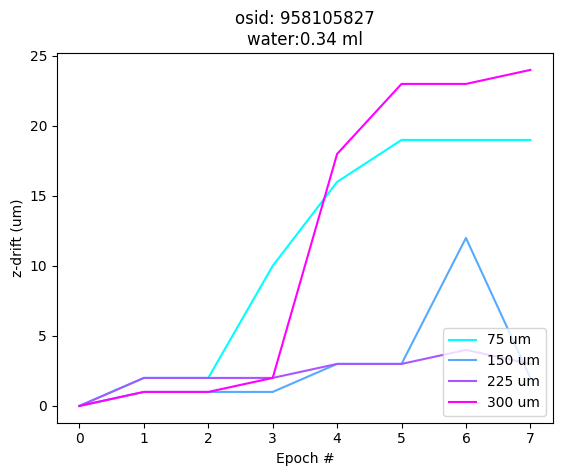

In [161]:
osids = 958105827
fig, ax = plt.subplots()
y_max = 0
y_min = 0
import matplotlib as mpl
colors = mpl.cm.get_cmap('cool')

temp_table = cc_table.query('ophys_session_id==@osid').sort_values(by='imaging_depth')
water = temp_table.water.unique()[0]
num_planes = len(temp_table)
for ii, oeid in enumerate(temp_table.index):
    zdrift = temp_table.loc[oeid, 'mpi_episodes']
    zdrift = zdrift - zdrift[0]
    ax.plot(range(len(zdrift)), zdrift,
                color=colors(ii/(num_planes-1)),
                label=f'{int(temp_table.loc[oeid, "imaging_depth"])} um')
ax.set_title(f'osid: {osid}\nwater:{water:.2f} ml')
ax.set_xlabel('Epoch #')
ax.set_ylabel('z-drift (um)')
y_max = max(y_max, ax.get_ylim()[1])
y_min = min(y_min, ax.get_ylim()[0])
ax.legend(loc='lower right')
ax.set_ylim(y_min, y_max)


Text(0.5, 1.0, '2x4, VISp (SST-Cre)')

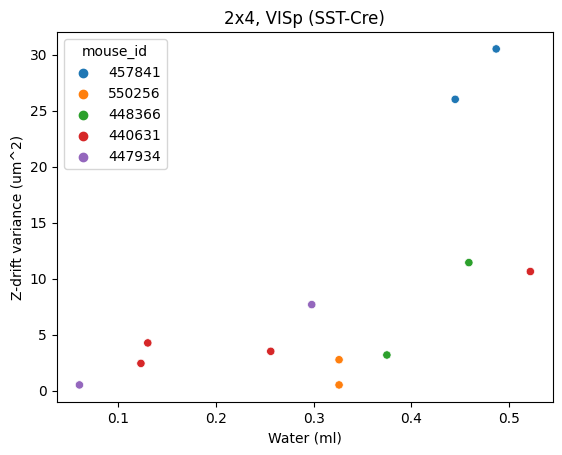

In [167]:
fig, ax = plt.subplots()
sns.scatterplot(session_table, x='water', y='zdrift_episodes_var', hue='mouse_id', ax=ax)
ax.set_ylabel('Z-drift variance (um^2)')
ax.set_xlabel('Water (ml)')
ax.set_title('2x4, VISp (SST-Cre)')

Text(0.5, 1.0, '2x4, VISp (SST-Cre)')

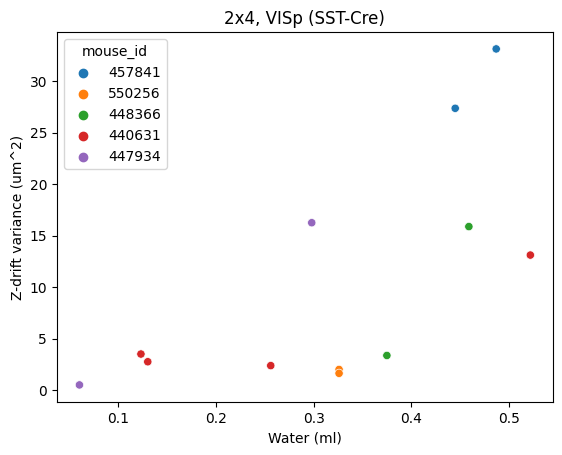

In [168]:
fig, ax = plt.subplots()
sns.scatterplot(session_table, x='water', y='zdrift_fl_var', hue='mouse_id', ax=ax)
ax.set_ylabel('Z-drift variance (um^2)')
ax.set_xlabel('Water (ml)')
ax.set_title('2x4, VISp (SST-Cre)')

In [176]:
sst_visl_table = vbm_table[vbm_table.cre_line.str.contains('Sst') &
                            (vbm_table.region=='VISl')]
sst_visl_table = sst_visl_table.merge(sst_visl_table.groupby('ophys_session_id')['zdrift_episodes'].var(),
                          left_on='ophys_session_id',
                          right_on='ophys_session_id',
                          suffixes=('', '_var'))
sst_visl_table = sst_visl_table.merge(sst_visl_table.groupby('ophys_session_id')['zdrift_fl'].var(),
                          left_on='ophys_session_id',
                          right_on='ophys_session_id',
                          suffixes=('', '_var')).set_index('oeid', drop=True)

cc_threshold = 0.7
cc_session_table = sst_visl_table.groupby('ophys_session_id').apply(lambda x: (x.min_cc_fl.min() >= cc_threshold) and (x.min_cc_episodes.min() >= cc_threshold))
osids = cc_session_table.index[cc_session_table]
cc_table = sst_visl_table.query('ophys_session_id in @osids').reset_index(drop=False)
print(len(osids))

19


<AxesSubplot:xlabel='zdrift_episodes_var', ylabel='zdrift_fl_var'>

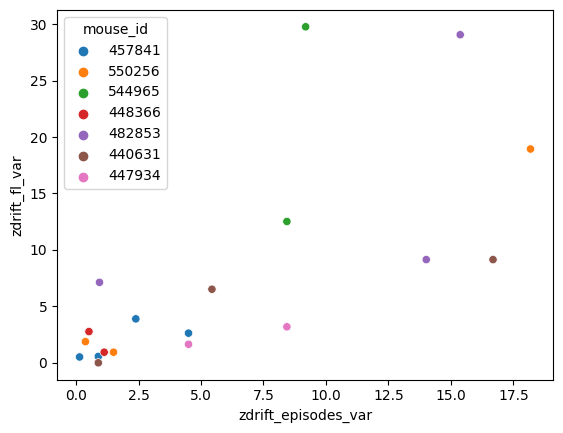

In [177]:
session_table = cc_table.set_index('ophys_session_id')[['mouse_id', 'water', 'zdrift_fl_var', 'zdrift_episodes_var']].drop_duplicates()
sns.scatterplot(session_table, x='zdrift_episodes_var', y='zdrift_fl_var', hue='mouse_id')

In [178]:
# checkout sessions with large difference between episodes var and fl var
session_table[abs(session_table.zdrift_fl_var.values - session_table.zdrift_episodes_var.values) > 10]

,mouse_id,water,zdrift_fl_var,zdrift_episodes_var
ophys_session_id,,,,
1078792791,544965,0.242,29.765625,9.1875
978201478,482853,0.620,29.062500,15.3750


In [172]:
osids = [976167513, 1078792791, 981845703]
check_table = cc_table.query('ophys_session_id in @osids')
check_table

,oeid,depth,region,mpi_episodes,cc_episodes,mpi_fl,cc_fl,osid,ophys_experiment_id,equipment_name,...,session_type,config,water,mouse_id,min_cc_episodes,min_cc_fl,zdrift_episodes,zdrift_fl,zdrift_episodes_var,zdrift_fl_var
32,1078904678,289,VISl,"[31, 31, 32, 34, 35, 35, 38, 35]","[0.914130801831315, 0.9113120978973701, 0.9157...","[33, 33]","[0.8454574538255327, 0.8165042581174458]",1078792791,1078904678,MESO.1,...,OPHYS_6_images_B,2x4,0.242,544965,0.852819,0.816504,3.00,0.00,9.1875,29.765625
33,1078904675,230,VISl,"[30, 31, 33, 36, 36, 37, 38, 38]","[0.9014127946924044, 0.8961084516034417, 0.892...","[30, 38]","[0.8746195876173999, 0.8605338727671784]",1078792791,1078904675,MESO.1,...,OPHYS_6_images_B,2x4,0.242,544965,0.874926,0.860534,6.00,6.00,9.1875,29.765625
34,1078904672,152,VISl,"[27, 27, 30, 33, 34, 35, 37, 40]","[0.8602021698531672, 0.847539858539531, 0.8882...","[24, 41]","[0.8039629082130834, 0.7882037508635563]",1078792791,1078904672,MESO.1,...,OPHYS_6_images_B,2x4,0.242,544965,0.860202,0.788204,9.75,12.75,9.1875,29.765625
35,1078904676,79,VISl,"[25, 24, 28, 31, 32, 33, 36, 30]","[0.8631790380503854, 0.7950802347252927, 0.851...","[26, 30]","[0.8712385093860137, 0.7647547213602952]",1078792791,1078904676,MESO.1,...,OPHYS_6_images_B,2x4,0.242,544965,0.794747,0.764755,3.75,3.00,9.1875,29.765625
44,976300307,225,VISl,"[21, 23, 25, 28, 32, 33, 37, 33]","[0.8577126800602627, 0.8733461237882861, 0.876...","[9, 37]","[0.8096262249539129, 0.8994973177231795]",976167513,976300307,MESO.1,...,OPHYS_1_images_A,2x4,0.256,482853,0.857713,0.809626,9.00,21.00,13.1250,94.125000
45,976300305,150,VISl,"[29, 31, 32, 33, 35, 37, 38, 39]","[0.8598815845031027, 0.8657494600404403, 0.860...","[27, 39]","[0.8060948725828844, 0.8415043665079759]",976167513,976300305,MESO.1,...,OPHYS_1_images_A,2x4,0.256,482853,0.834950,0.806095,7.50,9.00,13.1250,94.125000
46,976300303,284,VISl,"[31, 32, 33, 35, 37, 37, 38, 32]","[0.8572652585467835, 0.8815580462338161, 0.892...","[37, 34]","[0.8019648550183658, 0.8795014500851397]",976167513,976300303,MESO.1,...,OPHYS_1_images_A,2x4,0.256,482853,0.857265,0.801965,0.75,-2.25,13.1250,94.125000
47,976300301,75,VISl,"[32, 33, 35, 36, 37, 38, 38, 41]","[0.9066036270158245, 0.9197307888926108, 0.931...","[35, 42]","[0.8870522390729809, 0.8334082987851777]",976167513,976300301,MESO.1,...,OPHYS_1_images_A,2x4,0.256,482853,0.843412,0.833408,6.75,5.25,13.1250,94.125000
48,982343734,78,VISl,"[34, 35, 36, 38, 39, 40, 39, 39]","[0.8595221480948643, 0.8607795717257194, 0.863...","[33, 39]","[0.8521826680833899, 0.8860155862138923]",981845703,982343734,MESO.1,...,OPHYS_6_images_B,2x4,0.494,482853,0.859522,0.852183,3.75,4.50,3.1875,28.875000
49,982343741,229,VISl,"[32, 35, 35, 36, 37, 37, 37, 36]","[0.8975712487968541, 0.9321331637286209, 0.928...","[19, 37]","[0.787484740561093, 0.9246071914286456]",981845703,982343741,MESO.1,...,OPHYS_6_images_B,2x4,0.494,482853,0.870047,0.787485,3.00,13.50,3.1875,28.875000


In [174]:
oeid = 982343741
ocid = from_lims.get_ophys_container_id_for_ophys_experiment_id(oeid)
zdrift_fn = zdrift_dir / f'container_{ocid}' / f'experiment_{oeid}' / f'{oeid}_zdrift_ref_{oeid}.h5'
print(zdrift_fn.parent)

\\allen\programs\mindscope\workgroups\learning\ophys\zdrift\container_1018028215\experiment_982343741


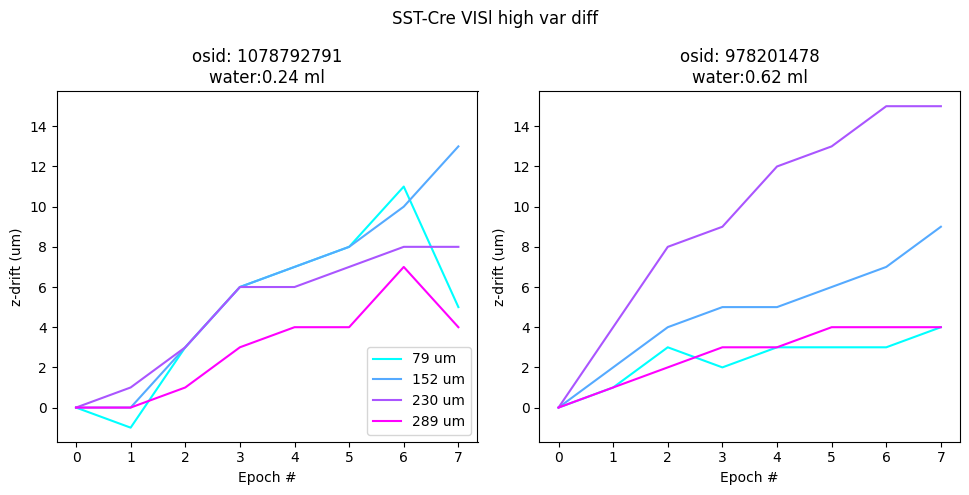

In [180]:
osids = session_table[abs(session_table.zdrift_fl_var.values - session_table.zdrift_episodes_var.values) > 10].index.values
fig, ax = plt.subplots(1, len(osids), figsize=(5*len(osids), 5))
y_max = 0
y_min = 0
import matplotlib as mpl
colors = mpl.cm.get_cmap('cool')
for i, osid in enumerate(osids):
    temp_table = cc_table.query('ophys_session_id== @osid').sort_values(by='imaging_depth')
    water = temp_table.water.unique()[0]
    num_planes = len(temp_table)
    for ii, oeid in enumerate(temp_table.index):
        zdrift = temp_table.loc[oeid, 'mpi_episodes']
        zdrift = zdrift - zdrift[0]
        ax[i].plot(range(len(zdrift)), zdrift,
                   color=colors(ii/(num_planes-1)),
                   label=f'{int(temp_table.loc[oeid, "imaging_depth"])} um')
    ax[i].set_title(f'osid: {osid}\nwater:{water:.2f} ml')
    ax[i].set_xlabel('Epoch #')
    ax[i].set_ylabel('z-drift (um)')
    y_max = max(y_max, ax[i].get_ylim()[1])
    y_min = min(y_min, ax[i].get_ylim()[0])
ax[0].legend(loc='lower right')
for i in range(len(osids)):
    ax[i].set_ylim(y_min, y_max)
    # ax[i].invert_yaxis()
fig.suptitle(f'SST-Cre VISl high var diff')
fig.tight_layout(rect=[0, 0, 0.98, 1])

Text(0.5, 1.0, '2x4, VISl (SST-Cre)')

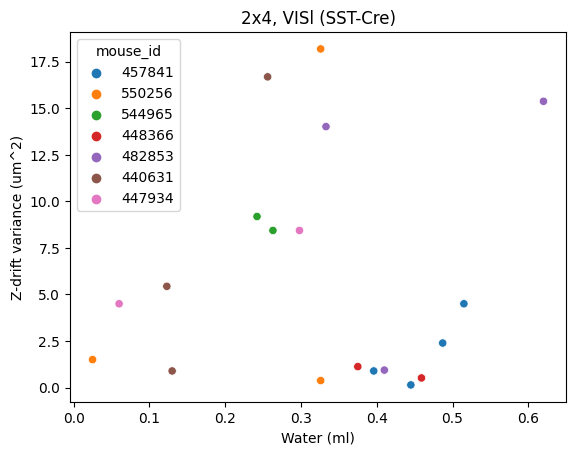

In [181]:
fig, ax = plt.subplots()
sns.scatterplot(session_table, x='water', y='zdrift_episodes_var', hue='mouse_id', ax=ax)
ax.set_ylabel('Z-drift variance (um^2)')
ax.set_xlabel('Water (ml)')
ax.set_title('2x4, VISl (SST-Cre)')

Text(0.5, 1.0, '2x4, VISl (SST-Cre)')

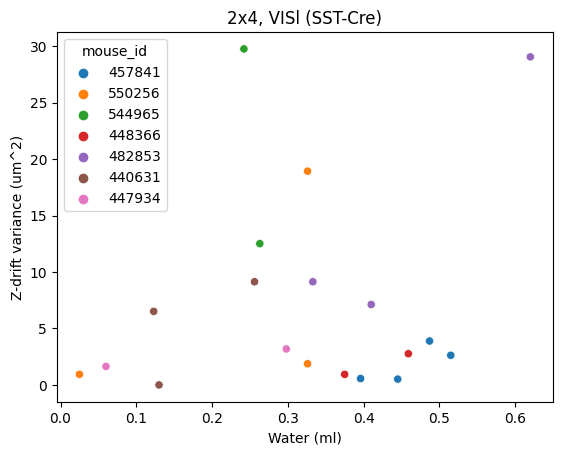

In [182]:
fig, ax = plt.subplots()
sns.scatterplot(session_table, x='water', y='zdrift_fl_var', hue='mouse_id', ax=ax)
ax.set_ylabel('Z-drift variance (um^2)')
ax.set_xlabel('Water (ml)')
ax.set_title('2x4, VISl (SST-Cre)')

# omFISH multiscope data
- No water
- Smaller inter-plane distance
- From 240325_multiplane_zdrift_comparison_other_lines.ipynb

In [3]:
omfish_fn = zdrift_dir / 'multiplane_zdrift_omfish.pkl'
omfish_table = pd.read_pickle(omfish_fn)
# removing single session case
omfish_table = omfish_table[~((omfish_table.cre_line=='Gad2-IRES-Cre') & (omfish_table.config=='1x8'))]
# set index with oeid
omfish_table.set_index('oeid', inplace=True)
# adding mouse_id
omfish_table.loc[:,'mouse_id'] = omfish_table.index.map(lambda x: table.loc[x].mouse_id)
omfish_table.groupby(['full_genotype', 'config']).apply(lambda x: len(x.mouse_id.unique()))


C:\Users\jinho.kim\AppData\Roaming\Python\Python38\site-packages\pandas\core\indexes\base.py:6999: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)


full_genotype                                                                config
Cux2-CreERT2/wt;Camk2a-tTA/wt;Ai93(TITL-GCaMP6f)/wt                          1x6       6
Gad2-IRES-Cre/wt;Slc32a1-T2A-FlpO/wt;Ai195(TIT2L-GC7s-ICF-IRES-tTA2)-hyg/wt  2x4       9
Gad2-IRES-Cre/wt;Slc32a1-T2A-FlpO/wt;Ai210(TITL-GC7f-ICF-IRES-tTA2)-hyg/wt   2x4       7
Rbp4-Cre_KL100/wt;Camk2a-tTA/wt;Ai93(TITL-GCaMP6f)/wt                        1x4       4
Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt                                1x8       5
dtype: int64

In [42]:
omfish_table.groupby(['full_genotype', 'config']).apply(lambda x: len(x.osid.unique()))

full_genotype                                                                config
Cux2-CreERT2/wt;Camk2a-tTA/wt;Ai93(TITL-GCaMP6f)/wt                          1x6       18
Gad2-IRES-Cre/wt;Slc32a1-T2A-FlpO/wt;Ai195(TIT2L-GC7s-ICF-IRES-tTA2)-hyg/wt  2x4       18
Gad2-IRES-Cre/wt;Slc32a1-T2A-FlpO/wt;Ai210(TITL-GC7f-ICF-IRES-tTA2)-hyg/wt   2x4       18
Rbp4-Cre_KL100/wt;Camk2a-tTA/wt;Ai93(TITL-GCaMP6f)/wt                        1x4       12
Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt                                1x8       14
dtype: int64

In [43]:
omfish_table.groupby(['cre_line', 'config']).apply(lambda x: len(x.mouse_id.unique()))

cre_line        config
Cux2-CreERT2    1x6        6
Gad2-IRES-Cre   2x4       16
Rbp4-Cre_KL100  1x4        4
Sst-IRES-Cre    1x8        5
dtype: int64

In [44]:
omfish_table.groupby(['cre_line', 'config']).apply(lambda x: len(x.osid.unique()))


cre_line        config
Cux2-CreERT2    1x6       18
Gad2-IRES-Cre   2x4       36
Rbp4-Cre_KL100  1x4       12
Sst-IRES-Cre    1x8       14
dtype: int64

In [46]:
omfish_table.groupby(['cre_line', 'config']).targeted_structure.unique()

cre_line        config
Cux2-CreERT2    1x6             [VISp]
Gad2-IRES-Cre   2x4       [VISp, VISl]
Rbp4-Cre_KL100  1x4             [VISp]
Sst-IRES-Cre    1x8             [VISp]
Name: targeted_structure, dtype: object

Text(0.5, 0.98, 'omFISH (no water)')

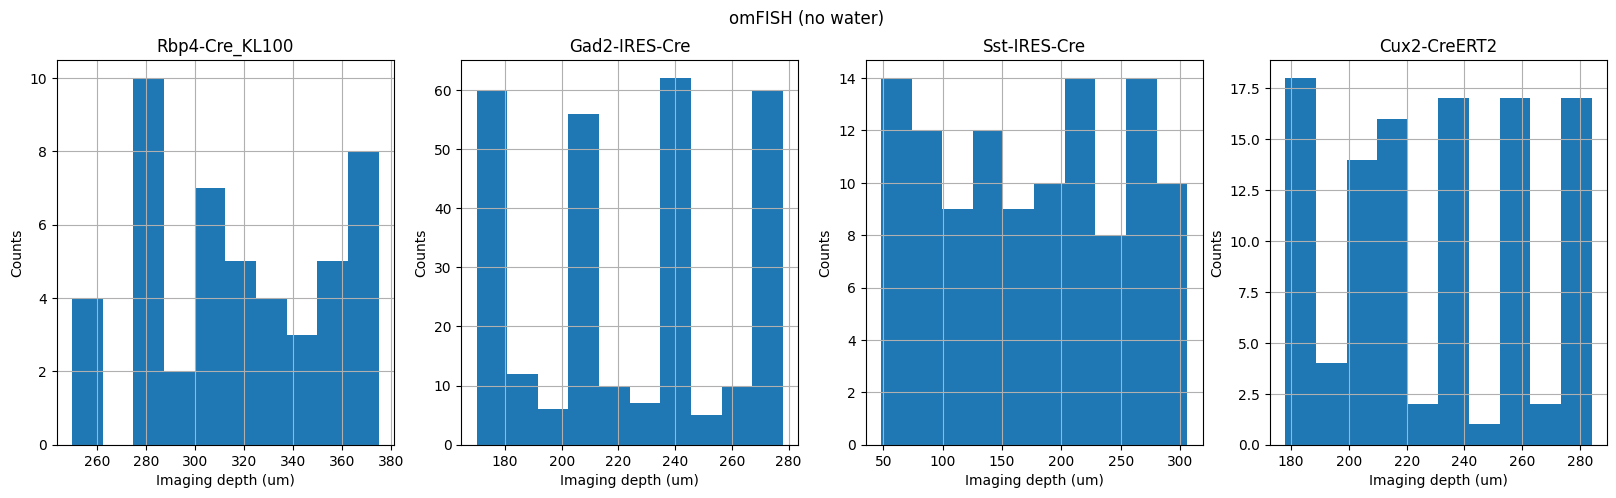

In [49]:
cre_lines = omfish_table.cre_line.unique()
fig, ax = plt.subplots(1, len(cre_lines), figsize=(5*len(cre_lines), 5))
for ci, cre_line in enumerate(cre_lines):
    omfish_table.query('cre_line==@cre_line').imaging_depth.hist(ax=ax[ci])
    ax[ci].set_xlabel('Imaging depth (um)')
    ax[ci].set_ylabel('Counts')
    ax[ci].set_title(cre_line)
fig.suptitle('omFISH (no water)')

Text(0.5, 0.98, 'omFISH (no water)')

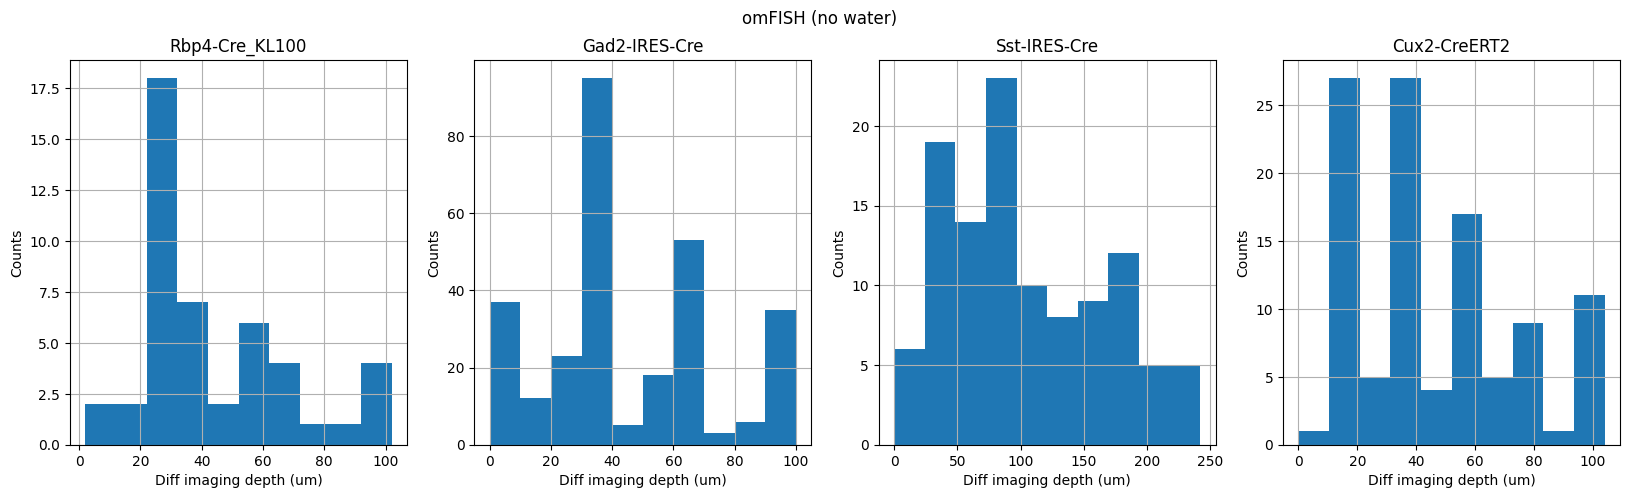

In [6]:
cre_lines = omfish_table.cre_line.unique()
fig, ax = plt.subplots(1, len(cre_lines), figsize=(5*len(cre_lines), 5))
for ci, cre_line in enumerate(cre_lines):
    omfish_table.query('cre_line==@cre_line').imaging_depth.diff().abs().hist(ax=ax[ci])
    ax[ci].set_xlabel('Diff imaging depth (um)')
    ax[ci].set_ylabel('Counts')
    ax[ci].set_title(cre_line)
fig.suptitle('omFISH (no water)')

## differences
- 30 um interval for Rbp4, GAD2, and Cux2.
- 50 um interval for Sst

## Error sessions (Crosstalk)
- Rbp4: 1311457885
- Cux2: 1209100658, 1217194411, 1217152913, 1223679413

In [63]:
error_osids = [1311457885, 1209100658, 1217194411, 1217152913, 1223679413]

In [72]:
cre_line = cre_lines[0]
cre_table = omfish_table.query('cre_line==@cre_line')
cre_table['zdrift_episodes'] = cre_table.apply(lambda x: (x.mpi_episodes[-1] - x.mpi_episodes[0]) * 0.75, axis=1)
print(cre_line)


Rbp4-Cre_KL100


C:\Users\jinho.kim\AppData\Local\Temp\ipykernel_13468\28570164.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cre_table['episode_drift'] = cre_table.apply(lambda x: (x.mpi_episodes[-1] - x.mpi_episodes[0]) * 0.75, axis=1)


In [10]:
def _return_depth_zdrift_diff_pair(session_table):
    unique_regions = session_table.targeted_structure.unique()
    depth_diff = []
    zdrift_diff = []
    for region in unique_regions:
        temp_table = session_table.query('targeted_structure==@region')
        for i in range(len(temp_table)-1):
            for j in range(i+1, len(temp_table)):
                depth_diff.append(abs(temp_table.iloc[i].imaging_depth - temp_table.iloc[j].imaging_depth))
                zdrift_diff.append(abs(temp_table.iloc[i].zdrift_episodes - temp_table.iloc[j].zdrift_episodes))
    return depth_diff, zdrift_diff

C:\Users\jinho.kim\AppData\Local\Temp\ipykernel_13468\2082255798.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cre_table['min_cc_episodes'] = cre_table.apply(lambda x: np.min(x['cc_episodes']), axis=1)


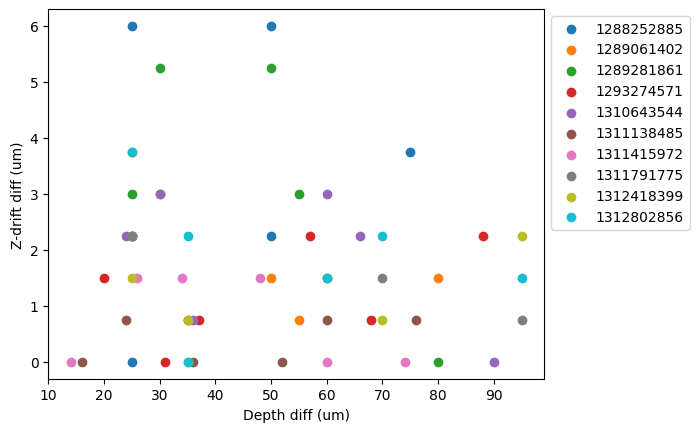

In [73]:
cre_table['min_cc_episodes'] = cre_table.apply(lambda x: np.min(x['cc_episodes']), axis=1)
cc_threshold = 0.7
passed_osids = cre_table.groupby('osid').apply(lambda x: np.min(x['min_cc_episodes']) >= cc_threshold)
passed_osids = passed_osids[passed_osids].index.values
# passed_osids = np.setdiff1d(passed_osids, 1311457885)
cre_table = cre_table.query('osid in @passed_osids')
depth_zdrift_pair = cre_table.groupby('osid').apply(lambda x: _return_depth_zdrift_diff_pair(x))
fig, ax = plt.subplots()
for i in range(len(depth_zdrift_pair)):
    depth_diff = depth_zdrift_pair.iloc[i][0]
    zdrift_diff = depth_zdrift_pair.iloc[i][1]
    ax.scatter(depth_diff, zdrift_diff, label=f'{depth_zdrift_pair.index[i].astype(int)}')
ax.set_xlabel('Depth diff (um)')
ax.set_ylabel('Z-drift diff (um)')
ax.legend(loc='upper left', bbox_to_anchor=(1,1))


## Plot them all in one figure, 
- hue with cre lines

In [69]:
passed_osids.index.values

array([1.15838620e+09, 1.15903500e+09, 1.16313245e+09, 1.16355756e+09,
       1.16429888e+09, 1.16452437e+09, 1.16557915e+09, 1.16558393e+09,
       1.16588314e+09, 1.17456671e+09, 1.17479437e+09, 1.17531314e+09,
       1.17660270e+09, 1.17682157e+09, 1.17712069e+09, 1.17771570e+09,
       1.17793046e+09, 1.17945991e+09, 1.17961538e+09, 1.17971356e+09,
       1.18007425e+09, 1.18133493e+09, 1.18180039e+09, 1.18242226e+09,
       1.18264698e+09, 1.18813968e+09, 1.19033041e+09, 1.19091555e+09,
       1.19116393e+09, 1.19165109e+09, 1.19433889e+09, 1.19503658e+09,
       1.19817857e+09, 1.19880496e+09, 1.20453633e+09, 1.20520067e+09,
       1.20910066e+09, 1.21124694e+09, 1.21440635e+09, 1.21473299e+09,
       1.21602720e+09, 1.21682313e+09, 1.21696946e+09, 1.21700128e+09,
       1.21715291e+09, 1.21719441e+09, 1.22340926e+09, 1.22367941e+09,
       1.22964084e+09, 1.22986360e+09, 1.25752705e+09, 1.25809199e+09,
       1.25838449e+09, 1.25870633e+09, 1.28825288e+09, 1.28906140e+09,
      

In [77]:
np.sort(omfish_table.osid.unique())

array([1158386203, 1159034997, 1163132450, 1163557557, 1164298882,
       1164524372, 1165579149, 1165583926, 1165883141, 1174566713,
       1174794367, 1175313136, 1176602697, 1176821572, 1177120686,
       1177715700, 1177930459, 1179459906, 1179615383, 1179713561,
       1180074253, 1181334933, 1181800386, 1182422265, 1182646975,
       1188139683, 1190330413, 1190915552, 1191163933, 1191651092,
       1194338889, 1195036584, 1198178572, 1198804955, 1204536330,
       1205200670, 1211246938, 1214406353, 1214732993, 1216027197,
       1216823133, 1216969462, 1217001280, 1223409259, 1229640845,
       1229863602, 1257527048, 1258091992, 1258384492, 1258706332,
       1288252885, 1289061402, 1289281861, 1290829184, 1292015489,
       1292220271, 1293274571, 1310643544, 1311138485, 1311415972,
       1311791775, 1312418399, 1312802856, 1321634549, 1325972210,
       1326218029, 1326457051, 1333399445, 1333959019, 1334298345,
       1335174733, 1336078216, 1336339512, 1336913811, 1337951

In [82]:
omfish_table.groupby('osid').apply(lambda x: np.min(x['min_cc_episodes']) >= cc_threshold)

osid
1158386203    True
1159034997    True
1163132450    True
1163557557    True
1164298882    True
              ... 
1335174733    True
1336078216    True
1336339512    True
1336913811    True
1337951485    True
Length: 75, dtype: bool

C:\Users\jinho.kim\AppData\Roaming\Python\Python38\site-packages\pandas\core\indexes\base.py:6999: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)


Text(0.5, 1.0, 'omFISH (no water)')

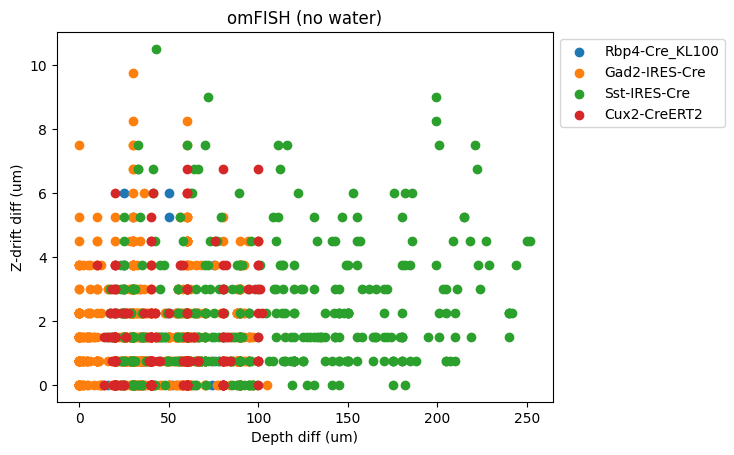

In [85]:
omfish_fn = zdrift_dir / 'multiplane_zdrift_omfish.pkl'
omfish_table = pd.read_pickle(omfish_fn)
omfish_table['osid'] = omfish_table['osid'].values.astype(int)
# removing single session case
omfish_table = omfish_table[~((omfish_table.cre_line=='Gad2-IRES-Cre') & (omfish_table.config=='1x8'))]
# set index with oeid
omfish_table.set_index('oeid', inplace=True)
# adding mouse_id
omfish_table.loc[:,'mouse_id'] = omfish_table.index.map(lambda x: table.loc[x].mouse_id)
omfish_table.groupby(['full_genotype', 'config']).apply(lambda x: len(x.mouse_id.unique()))

cc_threshold = 0.7
omfish_table['episode_drift'] = omfish_table.apply(lambda x: (x.mpi_episodes[-1] - x.mpi_episodes[0]) * 0.75, axis=1)
omfish_table['min_cc_episodes'] = omfish_table.apply(lambda x: np.min(x['cc_episodes']), axis=1)
passed_osids = omfish_table.groupby('osid').apply(lambda x: np.min(x['min_cc_episodes']) >= cc_threshold)
passed_osids = passed_osids[passed_osids]
passed_osids = passed_osids.index.values
error_osids = [1311457885, 1209100658, 1217194411, 1217152913, 1223679413]
omfish_table = omfish_table.query('osid in @passed_osids and osid not in @error_osids')

fig, ax = plt.subplots()
for crei, cre_line in enumerate(cre_lines):
    cre_table = omfish_table.query('cre_line==@cre_line')
    depth_zdrift_pair = cre_table.groupby('osid').apply(lambda x: _return_depth_zdrift_diff_pair(x))
    for i in range(len(depth_zdrift_pair)):
        depth_diff = depth_zdrift_pair.iloc[i][0]
        zdrift_diff = depth_zdrift_pair.iloc[i][1]
        if i == 0:
            ax.scatter(depth_diff, zdrift_diff, color=f'C{crei}', label=cre_line)
        else:
            ax.scatter(depth_diff, zdrift_diff, color=f'C{crei}')
ax.set_xlabel('Depth diff (um)')
ax.set_ylabel('Z-drift diff (um)')
ax.legend(loc='upper left', bbox_to_anchor=(1,1))
ax.set_title('omFISH (no water)')


In [80]:
passed_osids

array([1158386203, 1159034997, 1163132450, 1163557557, 1164298882,
       1164524372, 1165579149, 1165583926, 1165883141, 1174566713,
       1174794367, 1175313136, 1176602697, 1176821572, 1177120686,
       1177715700, 1177930459, 1179459906, 1179615383, 1179713561,
       1180074253, 1181334933, 1181800386, 1182422265, 1182646975,
       1188139683, 1190330413, 1190915552, 1191163933, 1191651092,
       1194338889, 1195036584, 1198178572, 1198804955, 1204536330,
       1205200670, 1209100658, 1211246938, 1214406353, 1214732993,
       1216027197, 1216823133, 1216969462, 1217001280, 1217152913,
       1217194411, 1223409259, 1223679413, 1229640845, 1229863602,
       1257527048, 1258091992, 1258384492, 1258706332, 1288252885,
       1289061402, 1289281861, 1290829184, 1292015489, 1292220271,
       1293274571, 1310643544, 1311138485, 1311415972, 1311457885,
       1311791775, 1312418399, 1312802856, 1321634549, 1325972210,
       1326218029, 1326457051, 1333399445, 1333959019, 1334298

In [81]:
cre_table.query('osid == 1290829184')

,depth,region,mpi_episodes,cc_episodes,mpi_fl,cc_fl,osid,ophys_experiment_id,equipment_name,full_genotype,...,ophys_session_id,project_code,imaging_depth,targeted_structure,date_of_acquisition,session_type,config,mouse_id,episode_drift,min_cc_episodes
oeid,,,,,,,,,,,,,,,,,,,,,
1290931960,250,VISp,"[56, 39, 38, 39, 39, 39]","[0.461415534587855, 0.840450583128039, 0.87719...","[13, 39]","[0.3076942411987753, 0.7968420168963039]",1290829184,1290931960,MESO.2,Rbp4-Cre_KL100/wt;Camk2a-tTA/wt;Ai93(TITL-GCaM...,...,1290829184,omFISHRbp4Meso,250,VISp,2023-08-17 21:10:43.916,STAGE_1,1x4,673151,-12.75,0.461416
1290931957,275,VISp,"[2, 37, 38, 38, 40, 40]","[0.47407228467144824, 0.9140574528037754, 0.92...","[4, 40]","[0.39761056371120634, 0.8732297329524626]",1290829184,1290931957,MESO.2,Rbp4-Cre_KL100/wt;Camk2a-tTA/wt;Ai93(TITL-GCaM...,...,1290829184,omFISHRbp4Meso,275,VISp,2023-08-17 21:10:43.916,STAGE_1,1x4,673151,28.50,0.474072
1290931954,300,VISp,"[73, 43, 37, 36, 38, 38]","[0.4842724264188283, 0.9053499562803093, 0.940...","[73, 39]","[0.5227875029802892, 0.8765547381467479]",1290829184,1290931954,MESO.2,Rbp4-Cre_KL100/wt;Camk2a-tTA/wt;Ai93(TITL-GCaM...,...,1290829184,omFISHRbp4Meso,300,VISp,2023-08-17 21:10:43.916,STAGE_1,1x4,673151,-26.25,0.484272
1290931949,330,VISp,"[56, 41, 39, 39, 42, 42]","[0.7868157809438875, 0.8647895177719782, 0.860...","[55, 42]","[0.6699103137124394, 0.7686822441718594]",1290829184,1290931949,MESO.2,Rbp4-Cre_KL100/wt;Camk2a-tTA/wt;Ai93(TITL-GCaM...,...,1290829184,omFISHRbp4Meso,330,VISp,2023-08-17 21:10:43.916,STAGE_1,1x4,673151,-10.50,0.786816


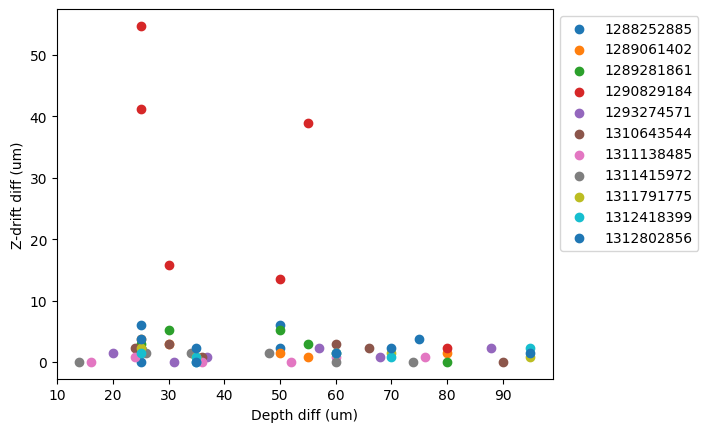

In [79]:
cre_line = cre_lines[0]
cre_table = omfish_table.query('cre_line==@cre_line')
depth_zdrift_pair = cre_table.groupby('osid').apply(lambda x: _return_depth_zdrift_diff_pair(x))
fig, ax = plt.subplots()
for i in range(len(depth_zdrift_pair)):
    depth_diff = depth_zdrift_pair.iloc[i][0]
    zdrift_diff = depth_zdrift_pair.iloc[i][1]
    ax.scatter(depth_diff, zdrift_diff, label=f'{depth_zdrift_pair.index[i].astype(int)}')
ax.set_xlabel('Depth diff (um)')
ax.set_ylabel('Z-drift diff (um)')
ax.legend(loc='upper left', bbox_to_anchor=(1,1))

In [60]:
osid = 1223679413
osid_table = cre_table.query('osid == @osid')
osid_table

,depth,region,mpi_episodes,cc_episodes,mpi_fl,cc_fl,osid,ophys_experiment_id,equipment_name,full_genotype,...,ophys_session_id,project_code,imaging_depth,targeted_structure,date_of_acquisition,session_type,config,mouse_id,episode_drift,min_cc_episodes
oeid,,,,,,,,,,,,,,,,,,,,,
1223843450,203,VISp,"[28, 32, 34, 34, 35, 35, 36, 38]","[0.9850894235317157, 0.984956676104327, 0.9852...","[28, 40]","[0.9783159637737958, 0.9819143267114526]",1.223679e+09,1223843450,MESO.2,Cux2-CreERT2/wt;Camk2a-tTA/wt;Ai93(TITL-GCaMP6...,...,1223679413,omFISHCux2Meso,203,VISp,2022-11-04 09:08:51.623,STAGE_1,1x6,641993,7.50,0.984957
1223843447,221,VISp,"[28, 31, 32, 33, 34, 34, 34, 36]","[0.979987452364517, 0.979518535019018, 0.97982...","[27, 37]","[0.9243881514035677, 0.9716451519410603]",1.223679e+09,1223843447,MESO.2,Cux2-CreERT2/wt;Camk2a-tTA/wt;Ai93(TITL-GCaMP6...,...,1223679413,omFISHCux2Meso,221,VISp,2022-11-04 09:08:51.623,STAGE_1,1x6,641993,6.00,0.973649
1223843453,180,VISp,"[22, 33, 34, 35, 36, 36, 38, 40]","[0.9711295388562303, 0.971623594908036, 0.9756...","[22, 41]","[0.97310692610614, 0.9816901290174759]",1.223679e+09,1223843453,MESO.2,Cux2-CreERT2/wt;Camk2a-tTA/wt;Ai93(TITL-GCaMP6...,...,1223679413,omFISHCux2Meso,180,VISp,2022-11-04 09:08:51.623,STAGE_1,1x6,641993,13.50,0.971130
1223843455,273,VISp,"[25, 26, 27, 28, 29, 28, 29, 29]","[0.9552994005087364, 0.9544424088140104, 0.950...","[24, 30]","[0.9404029331104515, 0.9345769244761584]",1.223679e+09,1223843455,MESO.2,Cux2-CreERT2/wt;Camk2a-tTA/wt;Ai93(TITL-GCaMP6...,...,1223679413,omFISHCux2Meso,273,VISp,2022-11-04 09:08:51.623,STAGE_1,1x6,641993,3.00,0.941832
1223843452,261,VISp,"[30, 34, 36, 36, 36, 36, 37, 39]","[0.938064573387916, 0.9455685623862042, 0.9494...","[29, 40]","[0.9179135729025033, 0.9533719697073404]",1.223679e+09,1223843452,MESO.2,Cux2-CreERT2/wt;Camk2a-tTA/wt;Ai93(TITL-GCaMP6...,...,1223679413,omFISHCux2Meso,261,VISp,2022-11-04 09:08:51.623,STAGE_1,1x6,641993,6.75,0.938065
1223843449,239,VISp,"[30, 33, 34, 35, 36, 37, 38, 40]","[0.9619942595883165, 0.9651548081002852, 0.965...","[29, 41]","[0.949391066070353, 0.9675833320113694]",1.223679e+09,1223843449,MESO.2,Cux2-CreERT2/wt;Camk2a-tTA/wt;Ai93(TITL-GCaMP6...,...,1223679413,omFISHCux2Meso,239,VISp,2022-11-04 09:08:51.623,STAGE_1,1x6,641993,7.50,0.961994


In [56]:
oeid = 1209386661
ocid = from_lims.get_ophys_container_id_for_ophys_experiment_id(oeid)
zdrift_fn = zdrift_dir / f'container_{ocid}' / f'experiment_{oeid}' / f'{oeid}_zdrift_ref_{oeid}.h5'
print(zdrift_fn.parent)

\\allen\programs\mindscope\workgroups\learning\ophys\zdrift\container_1255965420\experiment_1209386661


# Diff depth vs Diff z-drift with water
- First divide into < 0.6 and >= 0.6
- Also think about color-coded graph
- From GAD2 and Slc17a7 for Visual Behavior
    - SST and VIP data not good (not enough water? Too much crosstalk as well)
- On top of all omFISH mice (no water)

In [11]:
cc_threshold = 0.7

lamf_table_fn = zdrift_dir / 'multiplane_zdrift_lamf.pkl'
lamf_table = pd.read_pickle(lamf_table_fn)

lamf_table.set_index('oeid',inplace=True,drop=True)
# add mouse_id to it
lamf_table['mouse_id'] = table.loc[lamf_table.index, 'mouse_id']
lamf_table.reset_index(drop=False,inplace=True)

lamf_table['min_cc_episodes'] = lamf_table.apply(lambda x: np.min([x['cc_episodes'][0], x['cc_episodes'][-1]]), axis=1)
lamf_table['min_cc_fl'] = lamf_table.apply(lambda x: np.min(x.cc_fl), axis=1)
lamf_table['zdrift_episodes'] = lamf_table.apply(lambda x: plane_interval * (x.mpi_episodes[-1] - x.mpi_episodes[0]), axis=1)
lamf_table['zdrift_fl'] = lamf_table.apply(lambda x: plane_interval * (x.mpi_fl[1] - x.mpi_fl[0]), axis=1)

passed_osids = lamf_table.groupby('ophys_session_id').apply(lambda x: np.min(x['min_cc_episodes']) >= cc_threshold)
passed_osids = passed_osids[passed_osids]
passed_osids = passed_osids.index.values
lamf_table = lamf_table.query('ophys_session_id in @passed_osids')


vbm_table_fn = zdrift_dir / 'multiplane_zdrift_vbm.pkl'
vbm_table = pd.read_pickle(vbm_table_fn)
bad_imaging_sessions = [977760370, 1081070236, 1075872563, 906968227,
                        1088200327, 884613038, 921636320, 876303107,
                        923705570, 865024413, 958105827, 976167513, 981845703]
filtered_table = vbm_table[~vbm_table.ophys_session_id.isin(bad_imaging_sessions)]
vbm_table = filtered_table[~filtered_table.session_type.str.contains('passive') &
                              ~filtered_table.session_type.str.contains('OPHYS_7')].copy()
# add mouse IDs
vbm_table.set_index('oeid', inplace=True)
vbm_table['mouse_id'] = vbm_table.index.map(lambda x: table.loc[x].mouse_id)
vbm_table.reset_index(drop=False, inplace=True)

vbm_table['min_cc_episodes'] = vbm_table.apply(lambda x: np.min([x['cc_episodes'][0], x['cc_episodes'][-1]]), axis=1)
vbm_table['min_cc_fl'] = vbm_table.apply(lambda x: np.min(x.cc_fl), axis=1)
vbm_table['zdrift_episodes'] = vbm_table.apply(lambda x: plane_interval * (x.mpi_episodes[-1] - x.mpi_episodes[0]), axis=1)
vbm_table['zdrift_fl'] = vbm_table.apply(lambda x: plane_interval * (x.mpi_fl[1] - x.mpi_fl[0]), axis=1)

passed_osids = vbm_table.groupby('osid').apply(lambda x: np.min(x['min_cc_episodes']) >= cc_threshold)
passed_osids = passed_osids[passed_osids]
passed_osids = passed_osids.index.values
vbm_table = vbm_table.query('osid in @passed_osids')

exc_table = vbm_table[vbm_table.cre_line.str.contains('Slc17a7')].copy()

C:\Users\jinho.kim\AppData\Roaming\Python\Python38\site-packages\pandas\core\indexes\base.py:6999: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)
C:\Users\jinho.kim\AppData\Roaming\Python\Python38\site-packages\pandas\core\indexes\base.py:6999: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)


In [16]:
lamf_table.columns

Index(['oeid', 'depth', 'region', 'mpi_episodes', 'cc_episodes', 'mpi_fl',
       'cc_fl', 'ophys_experiment_id', 'equipment_name', 'full_genotype',
       'cre_line', 'indicator', 'ophys_session_id', 'project_code',
       'imaging_depth', 'targeted_structure', 'date_of_acquisition',
       'session_type', 'config', 'water', 'mouse_id', 'min_cc_episodes',
       'min_cc_fl', 'zdrift_episodes', 'zdrift_fl'],
      dtype='object')

1331788264


Text(0.5, 1.0, 'GAD2-Cre')

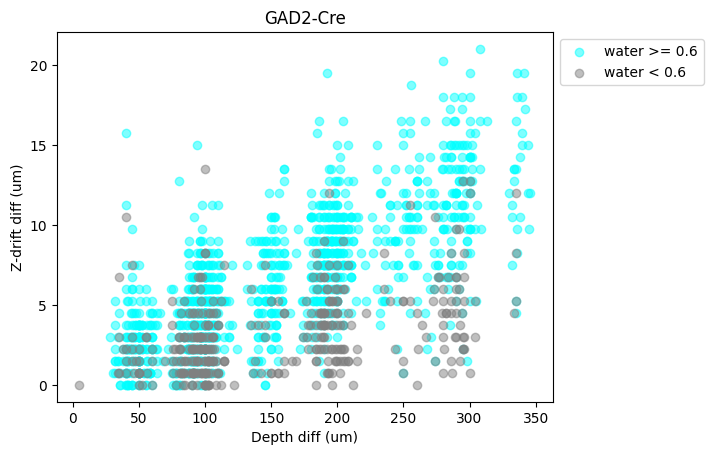

In [20]:
fig, ax = plt.subplots()

lamf_water_table = lamf_table.query('water >= 0.6')
depth_zdrift_pair = lamf_water_table.groupby('ophys_session_id').apply(lambda x: _return_depth_zdrift_diff_pair(x))
for i in range(len(depth_zdrift_pair)):
    depth_diff = depth_zdrift_pair.iloc[i][0]
    zdrift_diff = depth_zdrift_pair.iloc[i][1]
    if i == 0:
        ax.scatter(depth_diff, zdrift_diff, color='cyan', alpha=0.5, label='water >= 0.6')
    else:
        ax.scatter(depth_diff, zdrift_diff, color='cyan', alpha=0.5)

lamf_nowater_table = lamf_table.query('water < 0.6')
depth_zdrift_pair = lamf_nowater_table.groupby('ophys_session_id').apply(lambda x: _return_depth_zdrift_diff_pair(x))
for i in range(len(depth_zdrift_pair)):
    depth_diff = depth_zdrift_pair.iloc[i][0]
    zdrift_diff = depth_zdrift_pair.iloc[i][1]
    if min(depth_diff) < 20:
        print(depth_zdrift_pair.index.values[i])
    if i == 0:
        ax.scatter(depth_diff, zdrift_diff, color='gray', alpha=0.5, label='water < 0.6')
    else:
        ax.scatter(depth_diff, zdrift_diff, color='gray', alpha=0.5)


ax.set_xlabel('Depth diff (um)')
ax.set_ylabel('Z-drift diff (um)')
ax.legend(loc='upper left', bbox_to_anchor=(1,1))
ax.set_title('GAD2-Cre')

In [21]:
lamf_table.query('ophys_session_id == 1331788264')

,oeid,depth,region,mpi_episodes,cc_episodes,mpi_fl,cc_fl,ophys_experiment_id,equipment_name,full_genotype,...,targeted_structure,date_of_acquisition,session_type,config,water,mouse_id,min_cc_episodes,min_cc_fl,zdrift_episodes,zdrift_fl
120,1331941041,135,VISp,"[24, 28, 31, 34, 36, 38]","[0.8339000885973092, 0.8301530531893487, 0.855...","[20, 39]","[0.907986711072726, 0.9343177967292309]",1.331941e+09,MESO.2,Gad2-IRES-Cre/wt;Slc32a1-T2A-FlpO/wt;Ai195(TIT...,...,VISp,2024-02-19 18:20:02.969,TRAINING_4_images_A_training,1x8,0.158,710343,0.833900,0.907987,10.50,14.25
121,1331941027,40,VISp,"[20, 28, 32, 40, 41, 43]","[0.8153185786032309, 0.8051917221832918, 0.765...","[20, 43]","[0.8422628841399249, 0.8491724680091617]",1.331941e+09,MESO.2,Gad2-IRES-Cre/wt;Slc32a1-T2A-FlpO/wt;Ai195(TIT...,...,VISp,2024-02-19 18:20:02.969,TRAINING_4_images_A_training,1x8,0.158,710343,0.815319,0.842263,17.25,17.25
122,1331941045,335,VISp,"[33, 35, 36, 36, 37, 39]","[0.8877658675886324, 0.9122952270137108, 0.921...","[32, 40]","[0.893396437543492, 0.9385055999918334]",1.331941e+09,MESO.2,Gad2-IRES-Cre/wt;Slc32a1-T2A-FlpO/wt;Ai195(TIT...,...,VISp,2024-02-19 18:20:02.969,TRAINING_4_images_A_training,1x8,0.158,710343,0.887766,0.893396,4.50,6.00
123,1331941054,295,VISp,"[29, 32, 33, 34, 35, 37]","[0.9274770915529597, 0.9382234321897788, 0.946...","[28, 40]","[0.9234148596771735, 0.9301742050348777]",1.331941e+09,MESO.2,Gad2-IRES-Cre/wt;Slc32a1-T2A-FlpO/wt;Ai195(TIT...,...,VISp,2024-02-19 18:20:02.969,TRAINING_4_images_A_training,1x8,0.158,710343,0.927477,0.923415,6.00,9.00
124,1331941049,185,VISp,"[24, 26, 29, 32, 34, 37]","[0.8880685856209022, 0.8805742494180611, 0.883...","[22, 39]","[0.8709190948569627, 0.907510872804325]",1.331941e+09,MESO.2,Gad2-IRES-Cre/wt;Slc32a1-T2A-FlpO/wt;Ai195(TIT...,...,VISp,2024-02-19 18:20:02.969,TRAINING_4_images_A_training,1x8,0.158,710343,0.888069,0.870919,9.75,12.75
125,1331941034,85,VISp,"[25, 28, 30, 32, 35, 38]","[0.8087054763003633, 0.7742796063967015, 0.804...","[23, 41]","[0.9102148667963755, 0.9413737890012198]",1.331941e+09,MESO.2,Gad2-IRES-Cre/wt;Slc32a1-T2A-FlpO/wt;Ai195(TIT...,...,VISp,2024-02-19 18:20:02.969,TRAINING_4_images_A_training,1x8,0.158,710343,0.808705,0.910215,9.75,13.50
126,1331941038,340,VISp,"[32, 33, 34, 34, 36, 38]","[0.9071782926895362, 0.9242507979579924, 0.930...","[32, 39]","[0.9166815358291066, 0.9448046201421949]",1.331941e+09,MESO.2,Gad2-IRES-Cre/wt;Slc32a1-T2A-FlpO/wt;Ai195(TIT...,...,VISp,2024-02-19 18:20:02.969,TRAINING_4_images_A_training,1x8,0.158,710343,0.907178,0.916682,4.50,5.25
127,1331941031,375,VISp,"[32, 33, 36, 36, 38, 39]","[0.9069380296652562, 0.9199596334125235, 0.928...","[32, 39]","[0.916429346759348, 0.9299331818411127]",1.331941e+09,MESO.2,Gad2-IRES-Cre/wt;Slc32a1-T2A-FlpO/wt;Ai195(TIT...,...,VISp,2024-02-19 18:20:02.969,TRAINING_4_images_A_training,1x8,0.158,710343,0.906938,0.916429,5.25,5.25


Text(0.5, 1.0, 'Slc17a7-Cre')

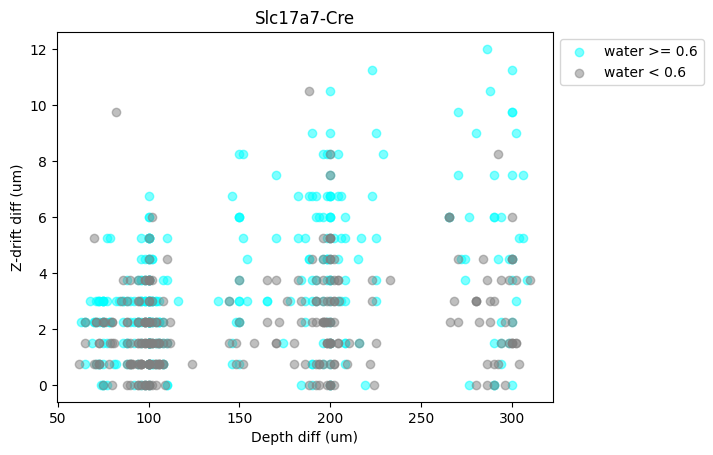

In [22]:
fig, ax = plt.subplots()

exc_water_table = exc_table.query('water >= 0.6')
depth_zdrift_pair = exc_water_table.groupby('ophys_session_id').apply(lambda x: _return_depth_zdrift_diff_pair(x))
for i in range(len(depth_zdrift_pair)):
    depth_diff = depth_zdrift_pair.iloc[i][0]
    zdrift_diff = depth_zdrift_pair.iloc[i][1]
    if i == 0:
        ax.scatter(depth_diff, zdrift_diff, color='cyan', alpha=0.5, label='water >= 0.6')
    else:
        ax.scatter(depth_diff, zdrift_diff, color='cyan', alpha=0.5)

exc_nowater_table = exc_table.query('water < 0.6')
depth_zdrift_pair = exc_nowater_table.groupby('ophys_session_id').apply(lambda x: _return_depth_zdrift_diff_pair(x))
for i in range(len(depth_zdrift_pair)):
    depth_diff = depth_zdrift_pair.iloc[i][0]
    zdrift_diff = depth_zdrift_pair.iloc[i][1]
    if min(depth_diff) < 20:
        print(depth_zdrift_pair.index.values[i])
    if i == 0:
        ax.scatter(depth_diff, zdrift_diff, color='gray', alpha=0.5, label='water < 0.6')
    else:
        ax.scatter(depth_diff, zdrift_diff, color='gray', alpha=0.5)

ax.set_xlabel('Depth diff (um)')
ax.set_ylabel('Z-drift diff (um)')
ax.legend(loc='upper left', bbox_to_anchor=(1,1))
ax.set_title('Slc17a7-Cre')

In [159]:
depth_zdrift_pair = lamf_table.groupby('ophys_session_id').apply(lambda x: _return_depth_zdrift_diff_pair(x))
depth_drift_df = pd.DataFrame(columns=['ophys_session_id', 'depth_diff', 'zdrift_diff'])
for i in range(len(depth_zdrift_pair)):
    temp_osid = depth_zdrift_pair.index.values[i]
    temp_depth_diff = depth_zdrift_pair.iloc[i][0]
    temp_zdrift_diff = depth_zdrift_pair.iloc[i][1]
    temp_df = pd.DataFrame({'ophys_session_id': temp_osid,
                            'depth_diff': temp_depth_diff,
                            'zdrift_diff': temp_zdrift_diff})
    depth_drift_df = pd.concat([depth_drift_df, temp_df])
depth_drift_df = depth_drift_df.merge(lamf_table[['ophys_session_id', 'water']].drop_duplicates(), left_on='ophys_session_id',
                                        right_on='ophys_session_id', how='inner')


(0.0, 360.0)

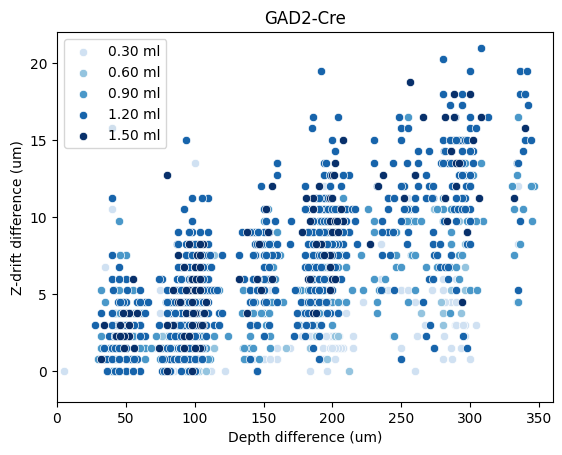

In [163]:
depth_drift_df = depth_drift_df[~depth_drift_df.water.isna()]
water_div_interval = 0.3
depth_drift_df['water_div'] = depth_drift_df.water.apply(lambda x: np.round((x//water_div_interval + 1)*water_div_interval,1))
depth_drift_df['depth_diff'] = depth_drift_df.depth_diff.values.astype(float)

num_water_div = len(depth_drift_df.water_div.unique())
colors = mpl.cm.get_cmap('Blues')
fig, ax = plt.subplots()
for wi, water in enumerate(np.sort(depth_drift_df.water_div.unique())):
    temp_df = depth_drift_df.query('water_div==@water')
    sns.scatterplot(temp_df, x='depth_diff', y='zdrift_diff', ax=ax, 
                color=colors((wi+1)/num_water_div),label=f'{water:.2f} ml'
                )
ax.legend()    
ax.set_title('GAD2-Cre')
ax.set_xlabel('Depth difference (um)')
ax.set_ylabel('Z-drift difference (um)')
ax.set_ylim(-2, 22)
ax.set_xlim(0, 360)

(0.0, 360.0)

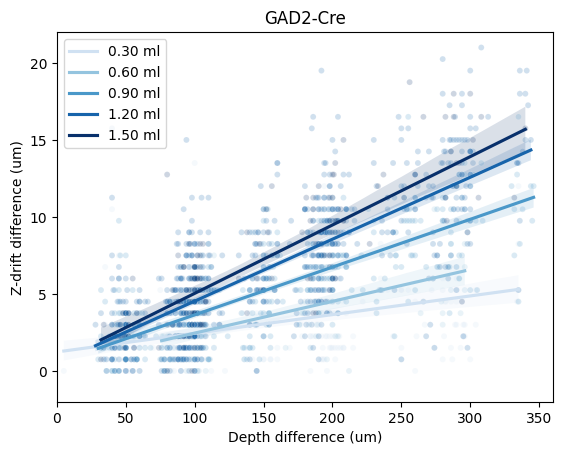

In [164]:
# run multiple regression on zdrift_diff based on depth_diff and water
depth_drift_df = depth_drift_df[~depth_drift_df.water.isna()]
water_div_interval = 0.3
depth_drift_df['water_div'] = depth_drift_df.water.apply(lambda x: np.round((x//water_div_interval + 1)*water_div_interval,1))
depth_drift_df['depth_diff'] = depth_drift_df.depth_diff.values.astype(float)

num_water_div = len(depth_drift_df.water_div.unique())
colors = mpl.cm.get_cmap('Blues')
fig, ax = plt.subplots()
for wi, water in enumerate(np.sort(depth_drift_df.water_div.unique())):
    temp_df = depth_drift_df.query('water_div==@water')
    sns.regplot(temp_df, x='depth_diff', y='zdrift_diff', ax=ax, 
                color=colors((wi+1)/num_water_div), label=f'{water:.2f} ml',
                scatter=False)
ax.legend()                
for wi, water in enumerate(np.sort(depth_drift_df.water_div.unique())):
    temp_df = depth_drift_df.query('water_div==@water')
    sns.scatterplot(temp_df, x='depth_diff', y='zdrift_diff', ax=ax, 
                color=colors((wi+1)/num_water_div),
                alpha=0.2, size=1, label=None, legend=False,
                )
ax.set_title('GAD2-Cre')
ax.set_xlabel('Depth difference (um)')
ax.set_ylabel('Z-drift difference (um)')
ax.set_ylim(-2, 22)
ax.set_xlim(0, 360)

In [165]:
depth_zdrift_pair = exc_table.groupby('ophys_session_id').apply(lambda x: _return_depth_zdrift_diff_pair(x))
depth_drift_df = pd.DataFrame(columns=['ophys_session_id', 'depth_diff', 'zdrift_diff'])
for i in range(len(depth_zdrift_pair)):
    temp_osid = depth_zdrift_pair.index.values[i]
    temp_depth_diff = depth_zdrift_pair.iloc[i][0]
    temp_zdrift_diff = depth_zdrift_pair.iloc[i][1]
    temp_df = pd.DataFrame({'ophys_session_id': temp_osid,
                            'depth_diff': temp_depth_diff,
                            'zdrift_diff': temp_zdrift_diff})
    depth_drift_df = pd.concat([depth_drift_df, temp_df])
depth_drift_df = depth_drift_df.merge(exc_table[['ophys_session_id', 'water']].drop_duplicates(), left_on='ophys_session_id',
                                        right_on='ophys_session_id', how='inner')

Text(0.5, 1.0, 'Slc17a7-Cre')

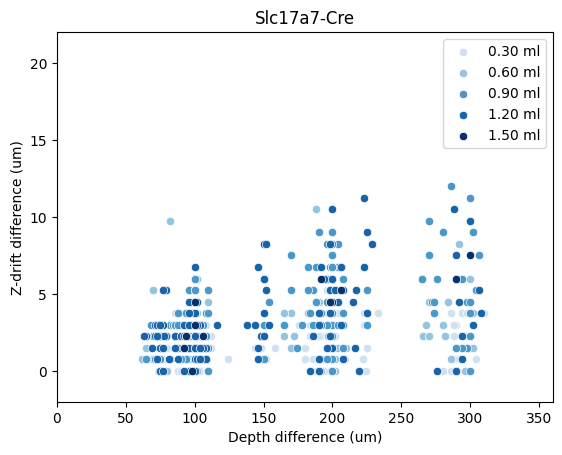

In [166]:
depth_drift_df = depth_drift_df[~depth_drift_df.water.isna()]
water_div_interval = 0.3
depth_drift_df['water_div'] = depth_drift_df.water.apply(lambda x: np.round((x//water_div_interval + 1)*water_div_interval,1))
depth_drift_df['depth_diff'] = depth_drift_df.depth_diff.values.astype(float)

num_water_div = len(depth_drift_df.water_div.unique())
colors = mpl.cm.get_cmap('Blues')
fig, ax = plt.subplots()
for wi, water in enumerate(np.sort(depth_drift_df.water_div.unique())):
    temp_df = depth_drift_df.query('water_div==@water')
    sns.scatterplot(temp_df, x='depth_diff', y='zdrift_diff', ax=ax, 
                color=colors((wi+1)/num_water_div),label=f'{water:.2f} ml'
                )
ax.legend()
ax.set_xlabel('Depth difference (um)')
ax.set_ylabel('Z-drift difference (um)')
ax.set_ylim(-2, 22)
ax.set_xlim(0, 360)
ax.set_title('Slc17a7-Cre')

In [137]:
import statsmodels.api as sm

# Create the X and y variables
X = temp_df['depth_diff'].values.astype(float)
y = temp_df['zdrift_diff'].values

# Add a constant term to the X variable
X = sm.add_constant(X)

# Fit the linear regression model
model = sm.OLS(y, X)
results = model.fit()

# Print the regression results
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.054
Model:                            OLS   Adj. R-squared:                  0.045
Method:                 Least Squares   F-statistic:                     6.075
Date:                Sat, 04 May 2024   Prob (F-statistic):             0.0153
Time:                        13:26:15   Log-Likelihood:                -227.85
No. Observations:                 108   AIC:                             459.7
Df Residuals:                     106   BIC:                             465.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.6348      0.469      3.485      0.0

In [139]:
from sklearn.linear_model import LinearRegression
X = temp_df['depth_diff'].values.reshape(-1, 1)
y = temp_df['zdrift_diff'].values.reshape(-1, 1)
model = LinearRegression()
model.fit(X, y)
intercept = model.intercept_
slope = model.coef_

In [141]:
slope

array([[0.00661249]])

(0.0, 360.0)

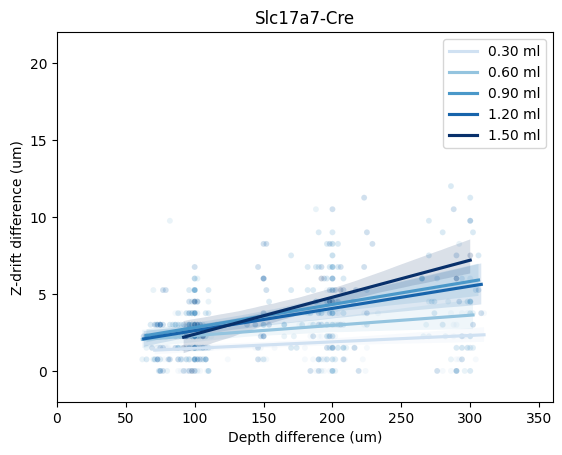

In [167]:
depth_drift_df = depth_drift_df[~depth_drift_df.water.isna()]
water_div_interval = 0.3
depth_drift_df['water_div'] = depth_drift_df.water.apply(lambda x: np.round((x//water_div_interval + 1)*water_div_interval,1))
depth_drift_df['depth_diff'] = depth_drift_df.depth_diff.values.astype(float)

num_water_div = len(depth_drift_df.water_div.unique())
colors = mpl.cm.get_cmap('Blues')
fig, ax = plt.subplots()
for wi, water in enumerate(np.sort(depth_drift_df.water_div.unique())):
    temp_df = depth_drift_df.query('water_div==@water')
    sns.regplot(temp_df, x='depth_diff', y='zdrift_diff', ax=ax, 
                color=colors((wi+1)/num_water_div), label=f'{water:.2f} ml',
                scatter=False)
    sns.scatterplot(temp_df, x='depth_diff', y='zdrift_diff', ax=ax, 
                color=colors((wi+1)/num_water_div),
                alpha=0.2, size=1, label=None, legend=False,
                )
ax.legend()                
    
ax.set_title('Slc17a7-Cre')
ax.set_xlabel('Depth difference (um)')
ax.set_ylabel('Z-drift difference (um)')
ax.set_ylim(-2, 22)
ax.set_xlim(0, 360)

# Difference between GAD2-Cre and Slc17a7-Cre
- Hydration speed?
- Running distance?

In [171]:
# from brain_observatory_utilities.datasets.optical_physiology import data_formatting as ophys_data_formatting
# from brain_observatory_utilities.datasets.behavior import data_formatting as behavior_data_formatting

In [208]:

len(lamf_table.ophys_session_id.unique())

98

In [209]:
len(exc_table.osid.unique())

47

In [207]:

oeid = 1275171148
ophys_data = BehaviorOphysExperiment.from_lims(oeid)
# stim_data = behavior_data_formatting.get_annotated_stimulus_presentations(ophys_data)

c:\users\jinho.kim\github\allensdk\allensdk\brain_observatory\behavior\data_objects\metadata\behavior_metadata\date_of_acquisition.py:79: UserWarning: The `date_of_acquisition` field in LIMS (2023-06-06 16:22:44.443000+00:00) for behavior session (1275054340) deviates by more than an hour from the `start_time` (2023-06-06 09:22:44.443000+00:00) specified in the associated stimulus *.pkl file: \\allen\programs\mindscope\production\learning\prod0\specimen_1264107343\behavior_session_1275054340\1275039517.pkl
  warnings.warn(
C:\Users\jinho.kim\AppData\Roaming\Python\Python38\site-packages\pandas\io\sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
C:\Users\jinho.kim\AppData\Roaming\Python\Python38\site-packages\pandas\io\sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase

In [189]:
rewards = ophys_data.rewards.copy()
rewards['acc_volume'] = rewards.volume.cumsum()

In [201]:
running = ophys_data.running_speed.copy()
running['dt'] = running.timestamps.diff()
running['run_dist'] = running.dt * running.speed
running['acc_run_dist'] = running.run_dist.cumsum()

<AxesSubplot:xlabel='timestamps', ylabel='acc_volume'>

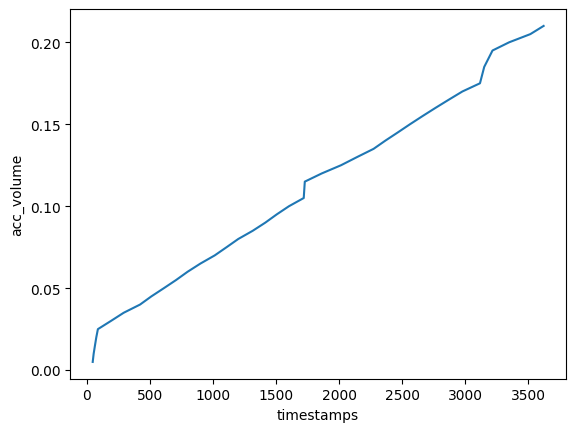

In [206]:
sns.lineplot(rewards, x='timestamps', y='acc_volume')

<AxesSubplot:xlabel='timestamps', ylabel='acc_run_dist'>

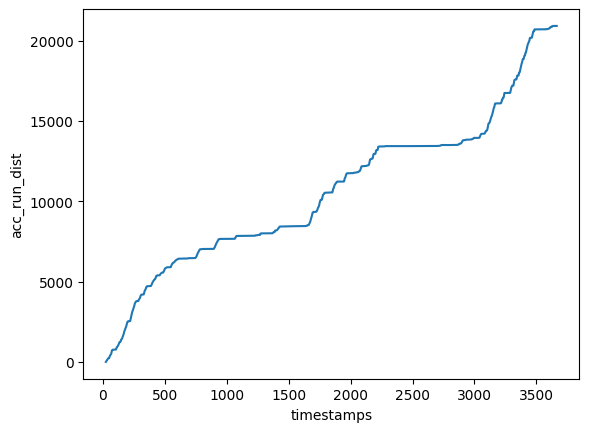

In [203]:
sns.lineplot(running, x='timestamps', y='acc_run_dist')

## Save data using multiprocessing
- qc/2p_data/z_drift/save_behavior_df.py
- 106/145 succeeded.
    - The rest could be done with removing projections from behavior_ophys_experiment object

In [9]:
def get_depth_drift_df(table):
    depth_zdrift_pair = table.groupby('ophys_session_id').apply(lambda x: _return_depth_zdrift_diff_pair(x))
    depth_drift_df = pd.DataFrame(columns=['ophys_session_id', 'depth_diff', 'zdrift_diff'])
    for i in range(len(depth_zdrift_pair)):
        temp_osid = depth_zdrift_pair.index.values[i]
        temp_depth_diff = depth_zdrift_pair.iloc[i][0]
        temp_zdrift_diff = depth_zdrift_pair.iloc[i][1]
        temp_df = pd.DataFrame({'ophys_session_id': temp_osid,
                                'depth_diff': temp_depth_diff,
                                'zdrift_diff': temp_zdrift_diff})
        depth_drift_df = pd.concat([depth_drift_df, temp_df])
    depth_drift_df = depth_drift_df.merge(table[['ophys_session_id', 'water']].drop_duplicates(), left_on='ophys_session_id',
                                            right_on='ophys_session_id', how='inner')
    return depth_drift_df

In [12]:
lamf_depth_zdrift = get_depth_drift_df(lamf_table)
exc_depth_zdrift = get_depth_drift_df(exc_table)

In [17]:
min_water = 0.8
len(exc_depth_zdrift.query('water > @min_water').ophys_session_id.unique())

16

In [61]:
timepoints = np.linspace(0,80,81)
exc_rewards = []
load_dir = zdrift_dir / 'behavior_df'
exc_depth_zdrift_water = exc_depth_zdrift.query('water > @min_water')
exc_water_osids = exc_depth_zdrift_water.ophys_session_id.unique()
for osid in exc_water_osids:
    fn = load_dir / f'osid_{osid}_rewards.pkl'
    rewards_df = pd.read_pickle(fn)
    acc_volume = np.append(0, rewards_df.acc_volume.values)
    t = np.append(0,rewards_df.timestamps.values / 60) # in min
    if t[-1] < 80:
        t = np.append(t, 80)
        acc_volume = np.append(acc_volume, acc_volume[-1])
    f = interp1d(t, acc_volume)
    y = f(timepoints)
    exc_rewards.append(y)
exc_rewards = np.stack(exc_rewards)

In [34]:
timepoints = np.linspace(0,60,61)
gad2_rewards = []
load_dir = zdrift_dir / 'behavior_df'
gad2_depth_zdrift_water = lamf_depth_zdrift.query('water > @min_water')
gad2_depth_zdrift_water = gad2_depth_zdrift_water.ophys_session_id.unique()
for osid in gad2_depth_zdrift_water:
    fn = load_dir / f'osid_{osid}_rewards.pkl'
    rewards_df = pd.read_pickle(fn)
    acc_volume = np.append(0, rewards_df.acc_volume.values)
    t = np.append(0,rewards_df.timestamps.values / 60) # in min
    if t[-1] < 60:
        t = np.append(t, 60)
        acc_volume = np.append(acc_volume, acc_volume[-1])
    f = interp1d(t, acc_volume)
    y = f(timepoints)
    gad2_rewards.append(y)
gad2_rewards = np.stack(gad2_rewards)

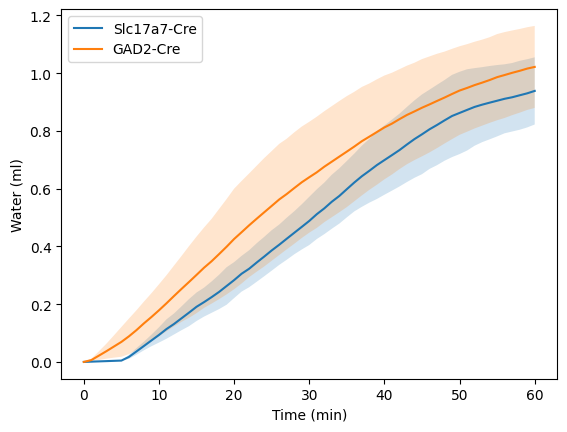

In [37]:
fig, ax = plt.subplots()
ax.fill_between(timepoints, 
np.mean(exc_rewards, axis=0) - np.std(exc_rewards, axis=0),
np.mean(exc_rewards, axis=0) + np.std(exc_rewards, axis=0), alpha=0.2)
ax.fill_between(timepoints, 
np.mean(gad2_rewards, axis=0) - np.std(gad2_rewards, axis=0),
np.mean(gad2_rewards, axis=0) + np.std(gad2_rewards, axis=0), alpha=0.2)

ax.plot(timepoints, np.mean(exc_rewards, axis=0), label='Slc17a7-Cre')
ax.plot(timepoints, np.mean(gad2_rewards, axis=0), label='GAD2-Cre')

ax.set_xlabel('Time (min)')
ax.set_ylabel('Water (ml)')
ax.legend(loc='upper left')

In [39]:
lamf_table.session_type.unique()

array(['TRAINING_1_gratings', 'TRAINING_2_gratings_flashed',
       'TRAINING_3_images_A_10uL_reward', 'OPHYS_1_images_A',
       'TRAINING_4_images_A_training', 'TRAINING_5_images_A_epilogue',
       'TRAINING_5_images_A_handoff_ready', 'OPHYS_6_images_B',
       'OPHYS_4_images_B'], dtype=object)

In [42]:
lamf_depth_zdrift.columns

Index(['ophys_session_id', 'depth_diff', 'zdrift_diff', 'water'], dtype='object')

(0.0, 360.0)

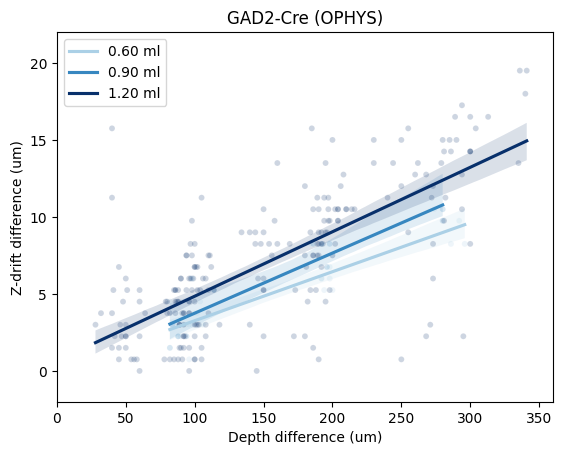

In [48]:
ophys_session_types = ['TRAINING_5_images_A_epilogue',
       'TRAINING_5_images_A_handoff_ready', 'OPHYS_4_images_B']
ophys_osids = lamf_table.query('session_type in @ophys_session_types').ophys_session_id.unique()

water_div_interval = 0.3
lamf_depth_zdrift['water_div'] = lamf_depth_zdrift.water.apply(lambda x: np.round((x//water_div_interval + 1)*water_div_interval,1))
lamf_depth_zdrift['depth_diff'] = lamf_depth_zdrift.depth_diff.values.astype(float)
lamf_ophys_depth_zdrift = lamf_depth_zdrift.query('ophys_session_id in @ophys_osids')

num_water_div = len(lamf_ophys_depth_zdrift.water_div.unique())
colors = mpl.cm.get_cmap('Blues')
fig, ax = plt.subplots()
for wi, water in enumerate(np.sort(lamf_ophys_depth_zdrift.water_div.unique())):
    temp_df = lamf_ophys_depth_zdrift.query('water_div==@water')
    sns.regplot(temp_df, x='depth_diff', y='zdrift_diff', ax=ax, 
                color=colors((wi+1)/num_water_div), label=f'{water:.2f} ml',
                scatter=False)
ax.legend()                
for wi, water in enumerate(np.sort(lamf_ophys_depth_zdrift.water_div.unique())):
    temp_df = lamf_ophys_depth_zdrift.query('water_div==@water')
    sns.scatterplot(temp_df, x='depth_diff', y='zdrift_diff', ax=ax, 
                color=colors((wi+1)/num_water_div),
                alpha=0.2, size=1, label=None, legend=False,
                )
ax.set_title('GAD2-Cre (OPHYS)')
ax.set_xlabel('Depth difference (um)')
ax.set_ylabel('Z-drift difference (um)')
ax.set_ylim(-2, 22)
ax.set_xlim(0, 360)

In [62]:
ophys_session_types = ['TRAINING_5_images_A_epilogue',
       'TRAINING_5_images_A_handoff_ready', 'OPHYS_4_images_B']
ophys_osids = lamf_table.query('session_type in @ophys_session_types').ophys_session_id.unique()
timepoints = np.linspace(0,80,81)
gad2_ophys_rewards = []
load_dir = zdrift_dir / 'behavior_df'
gad2_depth_zdrift_water = lamf_depth_zdrift.query('water > @min_water')
gad2_depth_zdrift_water = gad2_depth_zdrift_water.ophys_session_id.unique()
gad2_depth_zdrift_water_ophys = np.intersect1d(gad2_depth_zdrift_water, ophys_osids)
for osid in gad2_depth_zdrift_water_ophys:
    fn = load_dir / f'osid_{osid}_rewards.pkl'
    rewards_df = pd.read_pickle(fn)
    acc_volume = np.append(0, rewards_df.acc_volume.values)
    t = np.append(0,rewards_df.timestamps.values / 60) # in min
    if t[-1] < 80:
        t = np.append(t, 80)
        acc_volume = np.append(acc_volume, acc_volume[-1])
    f = interp1d(t, acc_volume)
    y = f(timepoints)
    gad2_ophys_rewards.append(y)
gad2_ophys_rewards = np.stack(gad2_ophys_rewards)

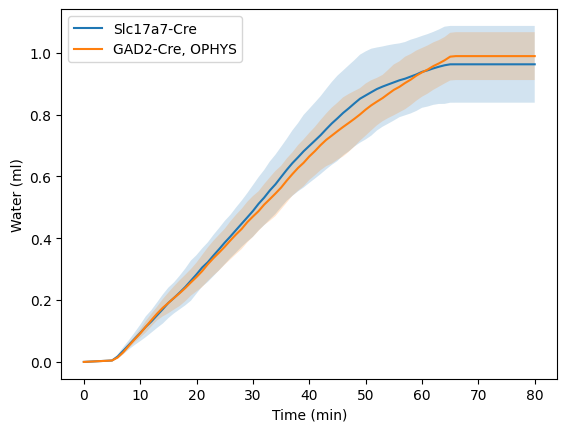

In [63]:
fig, ax = plt.subplots()
ax.fill_between(timepoints, 
np.mean(exc_rewards, axis=0) - np.std(exc_rewards, axis=0),
np.mean(exc_rewards, axis=0) + np.std(exc_rewards, axis=0), alpha=0.2)
ax.fill_between(timepoints, 
np.mean(gad2_ophys_rewards, axis=0) - np.std(gad2_ophys_rewards, axis=0),
np.mean(gad2_ophys_rewards, axis=0) + np.std(gad2_ophys_rewards, axis=0), alpha=0.2)

ax.plot(timepoints, np.mean(exc_rewards, axis=0), label='Slc17a7-Cre')
ax.plot(timepoints, np.mean(gad2_ophys_rewards, axis=0), label='GAD2-Cre, OPHYS')

ax.set_xlabel('Time (min)')
ax.set_ylabel('Water (ml)')
ax.legend(loc='upper left')

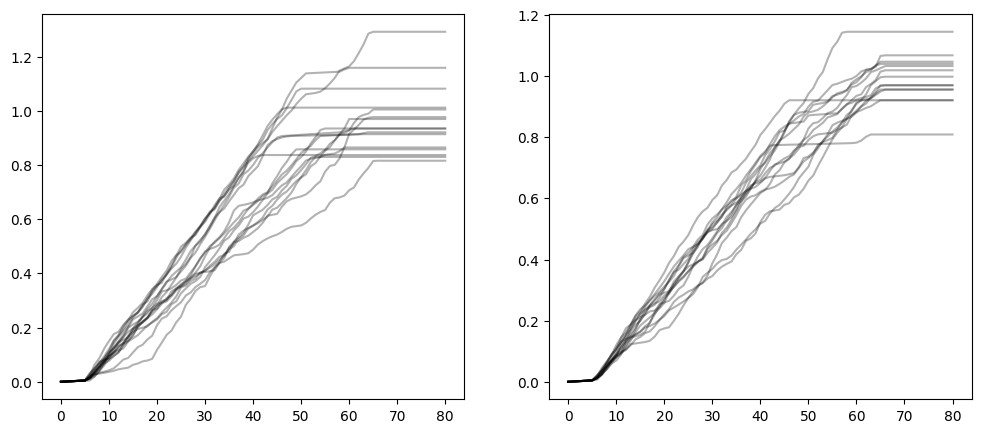

In [64]:
fig, ax = plt.subplots(1,2, figsize=(12,5))
for i in range(exc_rewards.shape[0]):
    ax[0].plot(timepoints, exc_rewards[i,:], 'k-', alpha=0.3)
for i in range(gad2_ophys_rewards.shape[0]):
    ax[1].plot(timepoints, gad2_ophys_rewards[i,:], 'k-', alpha=0.3)

## Matching times (5 epochs only)

In [73]:
cc_threshold = 0.7

cache = bpc.from_lims()
table = cache.get_ophys_experiment_table(passed_only=False)

lamf_table_fn = zdrift_dir / 'multiplane_zdrift_lamf.pkl'
lamf_table = pd.read_pickle(lamf_table_fn)

lamf_table.set_index('oeid',inplace=True,drop=True)
# add mouse_id to it
lamf_table['mouse_id'] = table.loc[lamf_table.index, 'mouse_id']
lamf_table.reset_index(drop=False,inplace=True)

lamf_table['min_cc_episodes'] = lamf_table.apply(lambda x: np.min([x['cc_episodes'][0], x['cc_episodes'][-1]]), axis=1)
lamf_table['min_cc_fl'] = lamf_table.apply(lambda x: np.min(x.cc_fl), axis=1)
lamf_table['zdrift_episodes'] = lamf_table.apply(lambda x: plane_interval * (x.mpi_episodes[-1] - x.mpi_episodes[0]), axis=1)
lamf_table['zdrift_fl'] = lamf_table.apply(lambda x: plane_interval * (x.mpi_fl[1] - x.mpi_fl[0]), axis=1)

passed_osids = lamf_table.groupby('ophys_session_id').apply(lambda x: np.min(x['min_cc_episodes']) >= cc_threshold)
passed_osids = passed_osids[passed_osids]
passed_osids = passed_osids.index.values
lamf_table = lamf_table.query('ophys_session_id in @passed_osids')


vbm_table_fn = zdrift_dir / 'multiplane_zdrift_vbm.pkl'
vbm_table = pd.read_pickle(vbm_table_fn)
bad_imaging_sessions = [977760370, 1081070236, 1075872563, 906968227,
                        1088200327, 884613038, 921636320, 876303107,
                        923705570, 865024413, 958105827, 976167513, 981845703]
filtered_table = vbm_table[~vbm_table.ophys_session_id.isin(bad_imaging_sessions)]
vbm_table = filtered_table[~filtered_table.session_type.str.contains('passive') &
                              ~filtered_table.session_type.str.contains('OPHYS_7')].copy()
# add mouse IDs
vbm_table.set_index('oeid', inplace=True)
vbm_table['mouse_id'] = vbm_table.index.map(lambda x: table.loc[x].mouse_id)
vbm_table.reset_index(drop=False, inplace=True)

vbm_table['min_cc_episodes'] = vbm_table.apply(lambda x: np.min([x['cc_episodes'][0], x['cc_episodes'][-1]]), axis=1)
vbm_table['min_cc_fl'] = vbm_table.apply(lambda x: np.min(x.cc_fl), axis=1)
vbm_table['zdrift_episodes'] = vbm_table.apply(lambda x: plane_interval * (x.mpi_episodes[-1] - x.mpi_episodes[0]), axis=1)
vbm_table['zdrift_fl'] = vbm_table.apply(lambda x: plane_interval * (x.mpi_fl[1] - x.mpi_fl[0]), axis=1)

passed_osids = vbm_table.groupby('osid').apply(lambda x: np.min(x['min_cc_episodes']) >= cc_threshold)
passed_osids = passed_osids[passed_osids]
passed_osids = passed_osids.index.values
vbm_table = vbm_table.query('osid in @passed_osids')

exc_table = vbm_table[vbm_table.cre_line.str.contains('Slc17a7')].copy()

C:\Users\jinho.kim\AppData\Roaming\Python\Python38\site-packages\pandas\core\indexes\base.py:6999: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)
C:\Users\jinho.kim\AppData\Roaming\Python\Python38\site-packages\pandas\core\indexes\base.py:6999: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)


In [74]:
lamf_table.groupby('ophys_session_id').apply(lambda x: np.mean(len(x.mpi_episodes))).unique()

array([8.])

In [75]:
exc_table.groupby('ophys_session_id').apply(lambda x: np.mean(len(x.mpi_episodes))).unique()

array([8.])

In [87]:
num_epochs = 5
max_timepoint = num_epochs * 600 # in s
exc_water_table = exc_table.query('water >= 0.6').copy()
exc_water_table['zdrift_episodes'] = exc_water_table.apply(lambda x: plane_interval * (x.mpi_episodes[num_epochs-1] - x.mpi_episodes[0]), axis=1)
gad2_water_table = lamf_table.query('water >= 0.6').copy()
gad2_water_table['zdrift_episodes'] = gad2_water_table.apply(lambda x: plane_interval * (x.mpi_episodes[num_epochs-1] - x.mpi_episodes[0]), axis=1)

exc_water_depth_zdrift = get_depth_drift_df(exc_water_table)
gad2_water_depth_zdrift = get_depth_drift_df(gad2_water_table)



In [82]:
water_timeseries_osids = [int(fn.name.split('_')[1]) for fn in list(load_dir.glob('osid_*_rewards.pkl'))]
print(np.isin(gad2_water_depth_zdrift.ophys_session_id.unique(), water_timeseries_osids).all())
print(np.isin(exc_water_depth_zdrift.ophys_session_id.unique(), water_timeseries_osids).all())


True
True


In [84]:
osid = gad2_water_depth_zdrift.ophys_session_id.unique()[0]
fn = load_dir / f'osid_{osid}_rewards.pkl'
rewards_df = pd.read_pickle(fn)
rewards_df.columns

Index(['volume', 'timestamps', 'autorewarded', 'acc_volume'], dtype='object')

In [88]:
rewards_df.timestamps.values

array([  61.69709,   69.21998,   81.63028,  105.61684,  124.91621,
        162.64753,  190.00356,  211.13775,  268.56863,  304.88203,
        327.46741,  337.87604,  370.71993,  411.6872 ,  462.42924,
        491.77021,  517.82513,  551.65318,  561.37791,  573.13766,
        605.26428,  623.54609,  654.33826,  664.19644,  693.9711 ,
        716.90679,  749.35031,  759.79233,  772.9199 ,  791.88558,
        802.79463,  872.41899,  898.92429,  921.09265,  930.80069,
        939.87489,  954.32021,  969.01569,  989.31585, 1004.42837,
       1022.89366, 1052.93523, 1061.17538, 1080.99182, 1134.7864 ,
       1173.75199, 1191.68353, 1203.49334, 1221.80849, 1228.96441,
       1237.55487, 1246.92931, 1295.45284, 1304.97739, 1312.48362,
       1321.52444, 1330.44851, 1376.83694, 1419.48895, 1445.92752,
       1469.31357, 1478.07085, 1486.94486, 1502.59114, 1513.11657,
       1539.88871, 1558.42074, 1567.82853, 1590.33052, 1616.96925,
       1646.96078, 1653.9499 , 1666.52698, 1689.27917, 1697.98

In [91]:
max_timepoint_ind = np.where(rewards_df.timestamps.values >= max_timepoint)[0][0]
water_timepoint = rewards_df.acc_volume.values[max_timepoint_ind]

(0.0, 360.0)

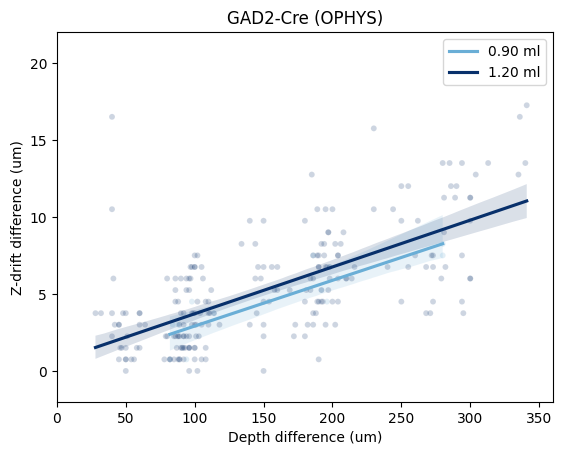

In [68]:
ophys_session_types = ['TRAINING_5_images_A_epilogue',
       'TRAINING_5_images_A_handoff_ready', 'OPHYS_4_images_B']
ophys_osids = lamf_table.query('session_type in @ophys_session_types').ophys_session_id.unique()

water_div_interval = 0.3
gad2_water_depth_zdrift['water_div'] = gad2_water_depth_zdrift.water.apply(lambda x: np.round((x//water_div_interval + 1)*water_div_interval,1))
gad2_water_depth_zdrift['depth_diff'] = gad2_water_depth_zdrift.depth_diff.values.astype(float)
gad2_water_depth_zdrift = gad2_water_depth_zdrift.query('ophys_session_id in @ophys_osids').copy()

num_water_div = len(gad2_water_depth_zdrift.water_div.unique())
colors = mpl.cm.get_cmap('Blues')
fig, ax = plt.subplots()
for wi, water in enumerate(np.sort(gad2_water_depth_zdrift.water_div.unique())):
    temp_df = gad2_water_depth_zdrift.query('water_div==@water')
    sns.regplot(temp_df, x='depth_diff', y='zdrift_diff', ax=ax, 
                color=colors((wi+1)/num_water_div), label=f'{water:.2f} ml',
                scatter=False)
ax.legend()                
for wi, water in enumerate(np.sort(gad2_water_depth_zdrift.water_div.unique())):
    temp_df = gad2_water_depth_zdrift.query('water_div==@water')
    sns.scatterplot(temp_df, x='depth_diff', y='zdrift_diff', ax=ax, 
                color=colors((wi+1)/num_water_div),
                alpha=0.2, size=1, label=None, legend=False,
                )
ax.set_title('GAD2-Cre (OPHYS)')
ax.set_xlabel('Depth difference (um)')
ax.set_ylabel('Z-drift difference (um)')
ax.set_ylim(-2, 22)
ax.set_xlim(0, 360)